# [MAFAT Challenge](https://competitions.codalab.org/competitions/19854) - Fine-Grained Classification of Objects from Aerial Imagery
![alt text](https://s3-us-west-2.amazonaws.com/codalab-webiks/Images/examples.jpg)

**Participants:** Nitzan Yogev, Eyal Gomel, Gal Aharoni


# Imports, Data Loading

* We start off by importing libraries and downloading the contest's dataset to the machine.
* Due to size & bandwith restrictions we pre-processed the dataset head of time.
* We therefore analyze and work on the preprocess images only.
* Explanation is given next at the *Input Pipeline* section.

In [0]:
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import zipfile
import urllib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import itertools


layers = tf.keras.layers  # for convenience

plt.style.use('default')  # nothing's like the default


TRAIN_CSV = 'https://docs.google.com/uc?export=download&id=1bSjV7oBnHLYIsmP43tFahbmyRYjXrazw'
TRAIN_ZIP = 'https://drive.google.com/uc?authuser=0&id=1lvjCMfmLubHoLQlr_FMHL7ws5U-W1a1h&export=download'
TEST_CSV = 'https://docs.google.com/uc?export=download&id=1_YLJZ2fompnMkwbU97H3jEsVRORoydcX'
TEST_ZIP = 'https://drive.google.com/uc?authuser=0&id=1Wu1bsGfKZgbpyrwW2KjEi_IWdcSSN4uA&export=download'

BLACK_TRAIN_ZIP = 'https://drive.google.com/uc?authuser=0&id=1109nJ7hrQAPECoNIhS7NBRq8OjdlPImJ&export=download'
BLACK_TEST_ZIP = 'https://drive.google.com/uc?authuser=0&id=1otT4iViNBYYSTgNpsiPvHSJVaiKY194B&export=download'

# download train csv, images zip and unzip
if not os.path.isdir('cropped'):
  urllib.request.urlretrieve(TRAIN_CSV, 'train.csv')
  urllib.request.urlretrieve(TRAIN_ZIP, 'cropped.zip')
  zipfile.ZipFile('cropped.zip').extractall()

# download test csv, images zip and unzip
if not os.path.isdir('test_cropped'):
  urllib.request.urlretrieve(TEST_CSV, 'test.csv')
  urllib.request.urlretrieve(TEST_ZIP, 'test_cropped.zip')
  zipfile.ZipFile('test_cropped.zip').extractall()
  
# download black train csv, images zip and unzip
if not os.path.isdir('black_train_images'):
  urllib.request.urlretrieve(BLACK_TRAIN_ZIP, 'black_train_images.zip')
  zipfile.ZipFile('black_train_images.zip').extractall()

# download black test csv, images zip and unzip
if not os.path.isdir('black_test_images'):
  urllib.request.urlretrieve(BLACK_TEST_ZIP, 'black_test_images.zip')
  zipfile.ZipFile('black_test_images.zip').extractall()

In [0]:
import requests


def download_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)
    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)
    save_response_content(response, destination)    

    
def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

  
def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                

# download pre-trained models zip and unzip
if not os.path.isdir('models'):
  download_from_google_drive('1UDOrs0x2s02K19Z_g0vo8g98LTnnfXJa', 'models.zip')
  zipfile.ZipFile('models.zip').extractall()

In [0]:
df = pd.read_csv('train.csv')
df.describe()

tag_id      image_id          p1_x          p_1y          p2_x  \
count  11617.000000  11617.000000  11617.000000  11617.000000  11617.000000   
mean   25113.216493  15041.335543    765.274719    527.833718    770.484425   
std     8698.591772   2896.027520    813.841324    556.642801    815.478281   
min    10001.000000  10002.000000    -19.580095    -15.461971     -6.049216   
25%    17622.000000  12666.000000    284.942535    177.853043    289.248555   
50%    25143.000000  14971.000000    542.917969    372.243561    548.786255   
75%    32677.000000  17711.000000    809.110901    562.029663    815.948120   
max    39999.000000  19998.000000   3996.879765   2677.496338   4009.340820   

               p2_y          p3_x          p3_y          p4_x          p4_y  \
count  11617.000000  11617.000000  11617.000000  11617.000000  11617.000000   
mean     520.288405    798.546638    533.068748    793.353873    540.583309   
std      558.753470    814.421006    562.096543    812.910175    559.911258   
min      -25.144509     -8.506227    -22.598812    -12.718300    -19.864586   
25%      169.826904    314.619019    182.907623    311.662598    192.147827   
50%      363.317322    579.818909    372.646973    575.973999    381.500000   
75%      554.393064    846.139526    569.901794    840.252502    580.214050   
max     2668.053374   4019.329590   2674.697754   4018.487793   2675.635986   

           ...       open_cargo_area  enclosed_cab   spare_wheel  \
count      ...          11617.000000  11617.000000  11617.000000   
mean       ...              0.022037     -0.028751     -0.027976   
std        ...              0.146809      0.239877      0.241578   
min        ...              0.000000     -1.000000     -1.000000   
25%        ...              0.000000      0.000000      0.000000   
50%        ...              0.000000      0.000000      0.000000   
75%        ...              0.000000      0.000000      0.000000   
max        ...              1.000000      1.000000      1.000000   

            wrecked       flatbed        ladder  enclosed_box  soft_shell_box  \
count  11617.000000  11617.000000  11617.000000  11617.000000    11617.000000   
mean       0.075837     -0.949815     -0.956185     -0.944908       -0.953775   
std        0.264749      0.246836      0.205532      0.273789        0.221941   
min        0.000000     -1.000000     -1.000000     -1.000000       -1.000000   
25%        0.000000     -1.000000     -1.000000     -1.000000       -1.000000   
50%        0.000000     -1.000000     -1.000000     -1.000000       -1.000000   
75%        0.000000     -1.000000     -1.000000     -1.000000       -1.000000   
max        1.000000      1.000000      1.000000      1.000000        1.000000   

       harnessed_to_a_cart      ac_vents  
count         11617.000000  11617.000000  
mean             -0.956013     -0.955927  
std               0.206748      0.233519  
min              -1.000000     -1.000000  
25%              -1.000000     -1.000000  
50%              -1.000000     -1.000000  
75%              -1.000000     -1.000000  
max               1.000000      1.000000  

[8 rows x 22 columns]

### Fix and Align CSV data

In [0]:
# fixing columns names
df.rename(str.strip, axis='columns', inplace=True)
df.rename(columns={"p_1y": "p1_y"}, inplace=True)

# setting columns desired dtypes
df['tag_id'] = df['tag_id'].astype(str)
df['image_id'] = df['image_id'].astype(str)
for col in list(df.select_dtypes(include='float').columns):
    df[col] = df[col].astype(int)

# adding cropped images columns
df['y_max'] = df[['p1_y', 'p2_y', 'p3_y', 'p4_y']].max(axis=1)
df['y_min'] = df[['p1_y', 'p2_y', 'p3_y', 'p4_y']].clip(0, axis=1).min(axis=1)
df['x_max'] = df[['p1_x', 'p2_x', 'p3_x', 'p4_x']].max(axis=1)
df['x_min'] = df[['p1_x', 'p2_x', 'p3_x', 'p4_x']].clip(0, axis=1).min(axis=1)
df['y_length'] = df['y_max'] - df['y_min']
df['x_length'] = df['x_max'] - df['x_min']
df['img_size'] = df['y_length'] * df['x_length']

df.describe()

p1_x          p1_y          p2_x          p2_y          p3_x  \
count  11617.000000  11617.000000  11617.000000  11617.000000  11617.000000   
mean     764.775760    527.340535    769.992081    519.810020    798.051218   
std      813.839285    556.636966    815.479674    558.740839    814.416570   
min      -19.000000    -15.000000     -6.000000    -25.000000     -8.000000   
25%      284.000000    177.000000    289.000000    169.000000    314.000000   
50%      542.000000    372.000000    548.000000    363.000000    579.000000   
75%      809.000000    562.000000    815.000000    554.000000    846.000000   
max     3996.000000   2677.000000   4009.000000   2668.000000   4019.000000   

               p3_y          p4_x          p4_y       sunroof  \
count  11617.000000  11617.000000  11617.000000  11617.000000   
mean     532.584746    792.854007    540.089696      0.029870   
std      562.085187    812.904385    559.899682      0.340737   
min      -22.000000    -12.000000    -19.000000     -1.000000   
25%      182.000000    311.000000    192.000000      0.000000   
50%      372.000000    575.000000    381.000000      0.000000   
75%      569.000000    840.000000    580.000000      0.000000   
max     2674.000000   4018.000000   2675.000000      1.000000   

       luggage_carrier      ...       soft_shell_box  harnessed_to_a_cart  \
count     11617.000000      ...         11617.000000         11617.000000   
mean         -0.010588      ...            -0.953775            -0.956013   
std           0.276442      ...             0.221941             0.206748   
min          -1.000000      ...            -1.000000            -1.000000   
25%           0.000000      ...            -1.000000            -1.000000   
50%           0.000000      ...            -1.000000            -1.000000   
75%           0.000000      ...            -1.000000            -1.000000   
max           1.000000      ...             1.000000             1.000000   

           ac_vents         y_max         y_min         x_max         x_min  \
count  11617.000000  11617.000000  11617.000000  11617.000000  11617.000000   
mean      -0.955927    556.706293    503.382543    807.319360    755.528536   
std        0.233519    556.969522    560.708478    812.962599    814.981297   
min       -1.000000      9.000000      0.000000     13.000000      0.000000   
25%       -1.000000    208.000000    151.000000    327.000000    273.000000   
50%       -1.000000    401.000000    342.000000    587.000000    533.000000   
75%       -1.000000    592.000000    534.000000    853.000000    799.000000   
max        1.000000   2677.000000   2659.000000   4019.000000   3996.000000   

           y_length      x_length      img_size  
count  11617.000000  11617.000000  11617.000000  
mean      53.323750     51.790824   2766.313506  
std       22.566105     22.901942   2157.763948  
min        5.000000      8.000000     40.000000  
25%       36.000000     34.000000   1725.000000  
50%       51.000000     48.000000   2400.000000  
75%       70.000000     67.000000   3285.000000  
max      280.000000    282.000000  47700.000000  

[8 rows x 27 columns]

In [0]:
test_df = pd.read_csv('test.csv')
test_df.describe()

tag_id      image_id          p1_x          p_1y          p2_x  \
count  11879.000000  11879.000000  11879.000000  11879.000000  11879.000000   
mean   24991.296490  15190.420911    458.552190    327.335053    465.513206   
std     8645.865778   2918.995521    301.077185    217.731162    302.091281   
min    10000.000000  10000.000000    -11.433413    -20.240116     -9.366598   
25%    17505.000000  12709.000000    222.669830    173.195050    229.732402   
50%    24954.000000  15278.000000    446.134286    314.574863    450.344501   
75%    32427.500000  17709.000000    668.465922    458.428055    677.867835   
max    40000.000000  19999.000000   3888.463135   2578.950684   3903.788818   

               p2_y          p3_x          p3_y          p4_x          p4_y  
count  11879.000000  11879.000000  11879.000000  11879.000000  11879.000000  
mean     307.106249    484.718273    313.077098    477.758297    333.301711  
std      219.874339    302.796793    221.496913    302.216586    218.823682  
min      -15.230139    -13.616144    -14.331875     -8.898283    -12.477217  
25%      152.443921    249.056009    155.876708    240.609400    178.657201  
50%      293.682246    471.598959    298.557692    465.897241    318.870402  
75%      435.307967    698.715507    440.885063    689.449033    464.214569  
max     2594.030139   3854.536865   2636.049316   3839.211182   2634.918945

## Blacking and Cropping

* The following code was used offline to crop the images from the given dataset.

In [0]:
import cv2
def black_and_crop(df, isTest = False):
  df1 = df.copy()
  if isTest:
    # fixing columns names
    df1.rename(str.strip, axis='columns', inplace=True)
    df1.rename(columns={"p_1y": "p1_y"}, inplace=True)

    # setting columns desired dtypes
    df1['tag_id'] = df1['tag_id'].astype(str)
    df1['image_id'] = df1['image_id'].astype(str)
    for col in list(df1.select_dtypes(include='float').columns):
        df1[col] = df1[col].astype(int)

    # adding cropped images columns
    df1['y_max'] = df1[['p1_y', 'p2_y', 'p3_y', 'p4_y']].max(axis=1)
    df1['y_min'] = df1[['p1_y', 'p2_y', 'p3_y', 'p4_y']].clip(0, axis=1).min(axis=1)
    df1['x_max'] = df1[['p1_x', 'p2_x', 'p3_x', 'p4_x']].max(axis=1)
    df1['x_min'] = df1[['p1_x', 'p2_x', 'p3_x', 'p4_x']].clip(0, axis=1).min(axis=1)
    df1['y_length'] = df1['y_max'] - df1['y_min']
    df1['x_length'] = df1['x_max'] - df1['x_min']
    df1['img_size'] = df1['y_length'] * df1['x_length']

    if not os.path.exists("test_cropped_BLACK"):
        os.makedirs("test_cropped_BLACK")

    folder_src = "test_imagery/"
    folder_output="test_cropped_BLACK/"
    
  else:
    if not os.path.exists("cropped_BLACK"):
      os.makedirs("cropped_BLACK")

    folder_src = "training_imagery/"
    folder_output="cropped_BLACK/"
  
  df1['xy1'] = list(zip(df1.p1_x, df1.p1_y))
  df1['xy2'] = list(zip(df1.p2_x, df1.p2_y))
  df1['xy3'] = list(zip(df1.p3_x, df1.p3_y))
  df1['xy4'] = list(zip(df1.p4_x, df1.p4_y))
  df1['xy1-4'] = list(zip(df1.xy1, df1.xy2, df1.xy3, df1.xy4))
  for img_name in os.listdir(folder_src):
    if not img_name.lower().endswith((".jpg",".png",".tif",".tiff")):
      continue
    img_path = folder_src+img_name
    img_id = img_name.split('.')[0]
    image = cv2.imread(img_path, -1)
    t = df1[df1['image_id'] == img_id]
    for z, line in t.iterrows():
      polygon = [line['xy1-4']]
      mask = np.zeros(image.shape, dtype=np.uint8)
      roi_corners = np.array(polygon, dtype=np.int32)
      cv2.fillPoly(mask, roi_corners, (255,)*image.shape[2])
      masked_image = cv2.bitwise_and(image, mask)
      RGB_img = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
      cropped_img = RGB_img[int(line['y_min']):int(line['y_max']), int(line['x_min']):int(line['x_max'])]
      plt.imsave( folder_output + str(line['tag_id'])+".png", cropped_img)

# black_and_crop(df)
# black_and_crop(test_df, True)

#  Data Exploration

In [0]:
len(df)

11617

 The dataset contains 11,617 tagged vehicles, classified into categories which are divided to four granularity levels:
* **General-class** - The category contains only two instances: Large vehicles and Small vehicles, according to the vehicle’s measurements.
*  **Sub-class** - 'Small' and 'Large' vehicles are divided according to their kind or designation. Small vehicles are divided into a sedan, hatchback, minivan, van, pickup truck, jeep, and public vehicle. Large vehicles are divided into a truck, light truck, cement mixer, a dedicated agricultural vehicle, crane truck, prime mover, tanker, bus, and minibus.
* **Features** - This category deals with the identification of each vehicles unique features. The features tagged in small vehicles were: sunroof, luggage carrier, open cargo area, enclosed cab, wrecked and spare wheel. The features tagged in large vehicles were: open cargo area, AC vents, wrecked, enclosed box, enclosed cab, ladder, flatbed, soft shell box and harnessed to a cart.
* **Color** - Identification of the vehicle’s color: white, grey/silver, blue, red, yellow
and other.

It should be noted that an object can be assigned with more than one feature, but is assigned to only one sub-class and only one color.



In [0]:
generalclass_names = df['general_class'].unique().tolist()
subclass_names = df['sub_class'].unique().tolist()
color_names = df['color'].unique().tolist()
features_names = ['sunroof', 'luggage_carrier', 'open_cargo_area',
                  'enclosed_cab', 'spare_wheel', 'wrecked', 'flatbed',
                  'ladder', 'enclosed_box', 'soft_shell_box',
                  'harnessed_to_a_cart', 'ac_vents']

### Data Distribution

In [0]:
# we zero unreachable features just for plotting
plot_df = df.copy()
plot_df[features_names] = plot_df[features_names].replace(-1, 0)

In [0]:
def plot_distribution(series):
  fig, ax = plt.subplots(1, 2, figsize=(12, 5))
  counts_plot = series.value_counts().plot
  # bar plot
  counts_plot.bar(ax=ax[0])
  for p in ax[0].patches:
    ax[0].annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.01))
  # pie plot
  counts_plot.pie(ax=ax[1], labels=None, radius=1.2, autopct='%.2f')

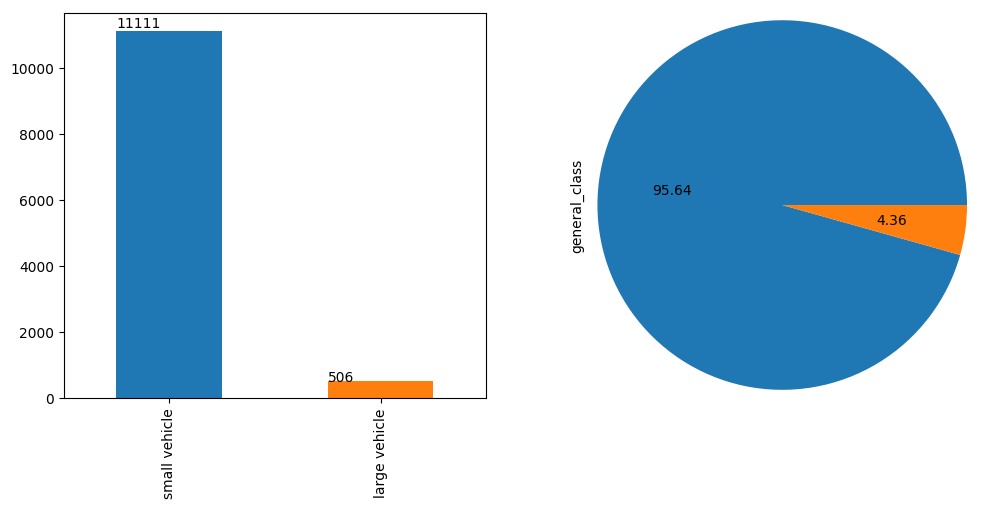

In [0]:
plot_distribution(df['general_class'])

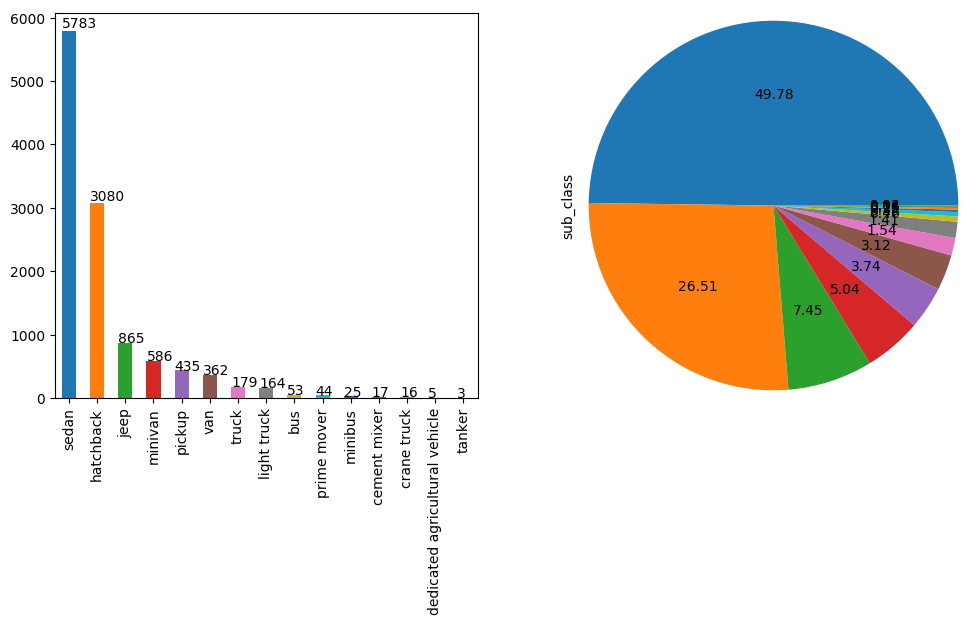

In [0]:
plot_distribution(df['sub_class'])

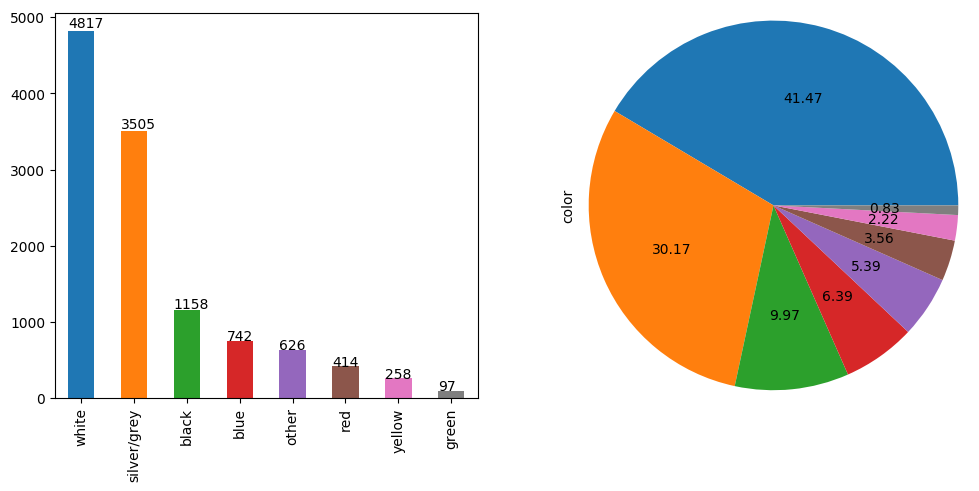

In [0]:
plot_distribution(df['color'])

**Conclusion:** Clearly, the challenge here is **CLASS IMBALANCE**, which is preset in every category of the features.

## Correlation Exploration

### Features Correlation

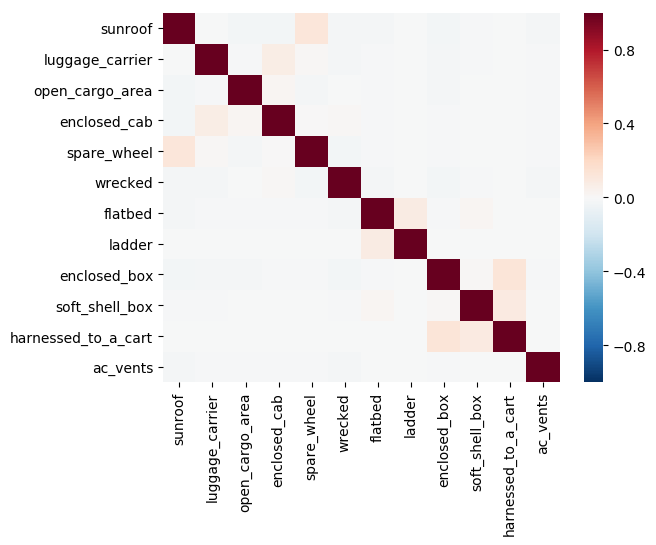

In [0]:
x = plot_df[features_names].corr()
sns.heatmap(x)

### Sub-class & Features Correlation

* Each object in the dataset is assigned to multi-label vector of features.
* These features are **not** independent.
* For example, most of the objects with ”spare wheel” are in the sub-class of ”jeep”.

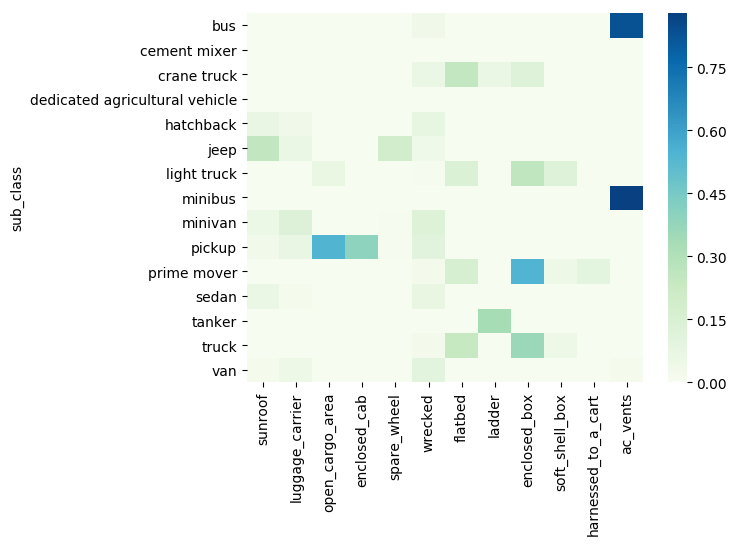

In [0]:
x = plot_df.groupby('sub_class')[features_names].agg('mean')
sns.heatmap(x, cmap='GnBu')

The above correlation plot is a measure of how the same feature is distributed in different sub-classes.
* The correlation can be seen in the value distributed in the **columns** of the heat map.
* High value means that the distribution of this feature has a peak for the specific sub-class.
* For example, the most common feature (in being shared through different sub-classes) is the feature of the vehicle being wrecked.
* It can also be seen that the most correlative sub-class (in having the most significant amount of different features) is a pickup.
* The most correlative pair of feature-sub-class is finding a minibus with air condition vents.

## Data Key Points
* Dataset is from an aerial view, and thus it has different symmetry properties than natural images (mainly approximate symmetry to rotations).
* The classes in the dataset are highly unbalanced - from few examples for some rare classes to thousands of examples of other classes.
* The classes with few training examples are not fit to the current deep learning classification
algorithms.
* The label of each object consists of multiple attributes which have some correlations between them, for example - a small vehicle cannot have the enclosed box feature.

# Proposed Baseline Solution

* Image classification is one of the fundamental tasks of computer vision. In the last decade, since the significant improvement in performance on the ImageNet dataset, the object classification task is dominated by convolutional neural networks (CNN) methods. We'll take advantage of that.
* The first step in our solution pipeline is to generate images for classification by cropping tiles of the objects according to the labeled bounding boxes.
* Although the objects are annotated by 8 points, we crop by the appropriate horizontal bounding boxes, using the quadruplet
$(x_{min}, y_{min}, x_{max}, y_{max})$.
* In order to feed the tiles to a standard CNN, we
warp the crops to a fixed size. The cropping was done offline.

**NOTE:**
* We tried both blackning out the bounding boxes pixels which were not part of the vehicle and leaving them as it.
* We got better results without blackning.

![alt text](https://www.dailytechnology.tech/wp-content/plugins/RSSPoster_PRO/cache/431cc_first_challenge-720x477.jpg)

## Input Pipeline

* We follow `tensorflow`'s' [input pipeline performance guide](https://www.tensorflow.org/guide/performance/datasets) in order to minimize processing time.
* We chose to focus on our augmentation process, which will be explained & expanded later on.

`tf.data.Dataset` features to note:
* Images are shuffled at dataset level, at the beginning of the dataset generation.
* Dataset is repeated (infinitely), thus learning steps are controlled via `fit()`'s `epochs` & `steps_per_epoch`.
* Augmentation is done in batch level (if done at all).

In [0]:
BATCH_SIZE = 1024

def input_fn(X, Y, batch_size=BATCH_SIZE, augment_fn=None):
  """
  Create tf.data.Dataset from np.arrays 
  """
  dataset = tf.data.Dataset.from_tensor_slices((X, Y))
  dataset = dataset.shuffle(batch_size)
  dataset = dataset.repeat()
  dataset = dataset.batch(batch_size, drop_remainder=True)
  if augment_fn:
    dataset = dataset.map(augment_fn, num_parallel_calls=4)
  return dataset

# Infrastructure & Utils

In [0]:
# create directory for models & training history
try:
  os.mkdir('models')
except OSError:
  pass

## Google's TPU Infrastructure

* TPU support for `tf.keras` interface is experimental, but working seamlessly for us.
* We get 8 TPU cores without time limit.
* Official code example can be found here: [Fashion MNIST](https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb), [Shakespeare](https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/shakespeare_with_tpu_and_keras.ipynb).

Restrictions:
* A fixed `batch_size` should be given to either the model input layer or to `fit()`.
* A TPU model cannot currently handle multiple outputs.
* Data given to `fit()` & `predict()` should be stored on machine's RAM (not on HD).

The following function allows us to transform a `tf.keras.Model` into a TPU-based model.

In [0]:
def to_tpu_model(model):
  """
  Convert a tf.keras model to TPU model
  """
  return model
#   TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
#   return tf.contrib.tpu.keras_to_tpu_model(
#     model,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#       tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))

## Load data to RAM

Due to TPU restrictions, we load the entire images (for training & testing) to RAM.
* Images are resized to a fixed size base on the mean & median sizes of the train images.
* Images RGB values are normalized to 0-1 scale.
* We introduce an option to keep the aspect ratio of the images while resizing.

In [0]:
X_train_mean_size = int(df['x_length'].mean()), int(df['y_length'].mean())
X_train_median_size = int(df['x_length'].median()), int(df['y_length'].median())
print(f'X_train_mean_size = {X_train_mean_size} pixels')
print(f'X_train_median_size = {X_train_median_size} pixels')

# Based on mean & median size, we resize all images to the following fixed size:
IMG_SHAPE = (48, 48, 3)

X_train_mean_size = (51, 53) pixels
X_train_median_size = (48, 51) pixels


In [0]:
def resize_and_pad(image, shape):
  """
  Resize a PIL.Image in place while keep it's aspect ratio
  Blank values are colored black
  """
  image.thumbnail(shape[:2], Image.ANTIALIAS)
  new_image = Image.new(image.mode, shape[:2])
  image.thumbnail(shape[:2], Image.ANTIALIAS)
  x_offset = (new_image.size[0] - image.size[0]) // 2
  y_offset = (new_image.size[1] - image.size[1]) // 2
  new_image.paste(image, (x_offset, y_offset))
  return new_image  


def load_image(filename, shape, keep_ratio=True):
  """
  Load a PIL.Image, resize it to IMG_SHAPE
  """
  img = Image.open(filename).convert('RGB')
  img = resize_and_pad(img, shape) if keep_ratio else img.resize(shape[:2])
  return np.array(img)


def load_images(filenames, shape=IMG_SHAPE, normalize=True, keep_ratio=True):
  """
  Load images to machine's RAM.
  """
  images = np.empty([len(filenames), *shape], dtype=np.float32)
  for i, filename in enumerate(filenames):
    images[i] = load_image(filename, shape, keep_ratio=keep_ratio)
  return images / 255 if normalize else images

In [0]:
images_train_path = df['tag_id'].map(lambda tag: f'cropped/{tag}.png')
X_train = load_images(images_train_path)

images_test_path = test_df['tag_id'].map(lambda tag: f'test_cropped/{tag}.png')
X_test = load_images(images_test_path)

black_images_train_path = df['tag_id'].map(lambda tag: f'black_train_images/{tag}.png')
X_train_black = load_images(black_images_train_path)

black_images_test_path = test_df['tag_id'].map(lambda tag: f'black_test_images/{tag}.png')
X_test_black = load_images(black_images_test_path)

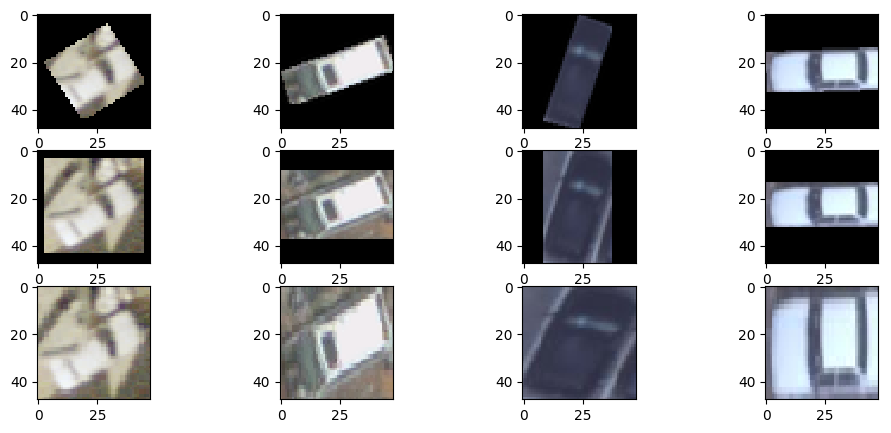

In [0]:
# comparing images with & without aspect rastio resize

indices_to_plot = [500, 10000, 5000, 9000]
fig, ax = plt.subplots(nrows=3, ncols=len(indices_to_plot), figsize=(12, 5))
for i, j in enumerate(indices_to_plot):
  ax[0, i].imshow(load_image(black_images_train_path[j], shape=(48, 48, 3), keep_ratio=True))
  ax[1, i].imshow(load_image(images_train_path[j], shape=(48, 48, 3), keep_ratio=True))
  ax[2, i].imshow(load_image(images_train_path[j], shape=(48, 48, 3), keep_ratio=False))
  ax[0, i].grid(False)
  ax[1, i].grid(False)

## MAFAT's Grader Automation

* [MAFAT's grader](https://grader.mafatchallenge.com/) is an online tool designed to calculate score against the public test set.
* We use [selenium](https://selenium-python.readthedocs.io/) to interact with it and automate that proccess.
* The `grade()` function takes a `pd.DataFrame` of predictions and does all the magic.
* **NOTE**: We do not recognize a way of getting labels for the test dataset.

In [0]:
# install selenium and add to python's path. see here for more info:
# https://stackoverflow.com/questions/51046454/how-can-we-use-selenium-webdriver-in-colab-research-google-com

!pip install selenium > /dev/null
!apt install chromium-chromedriver > /dev/null
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0, '/usr/lib/chromium-browser/chromedriver')

In [0]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import json


chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [0]:
def grade(df, timeout=30):
  """
  Grade a predictions pd.DataFrame using MAFAT's Grader.
  Returns the final score and average precision per class.
  """
  # save DataFrame and zip it as instructed
  df.to_csv('answer.csv', index=False)
  zipfile.ZipFile('answer.zip', mode='w').write('answer.csv')
  try:
    # upload zip to grader website, click and wait for results
    driver = webdriver.Chrome('chromedriver', options=chrome_options)
    driver.get('https://grader.mafatchallenge.com/')
    driver.find_element_by_name('fileUpload').send_keys('/content/answer.zip')
    driver.find_element_by_class_name('btn-dark').click()
    WebDriverWait(driver, timeout).until(
      EC.text_to_be_present_in_element((By.CLASS_NAME, 'scores'), 'Your Score')
    )
    scores_element = driver.find_element_by_class_name('scores')
    # parse results
    x = scores_element.text.split('\n')
    final_score = float(x[1].split()[-1])
    avg_precision = json.loads(x[-1].replace("\'", "\""))
  finally:
    driver.quit()
  return final_score, avg_precision

## Plotting Helper Functions

In [0]:
def plot_models_history(names):
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
  for name in names:
    df = pd.read_csv(f'models/{name}.csv')
    ax[0].plot(df['acc'], label=name)
    ax[1].plot(df['loss'], label=name)
  ax[0].set_title('Accuracy')
  ax[1].set_title('Loss')
  ax[0].legend()
  ax[1].legend()
  ax[0].grid()
  ax[1].grid()

In [0]:
def plot_grades(grades, model_name, ax=None):
  if not ax:
    _, ax = plt.subplots(figsize=(13, 5))
  y_pos = np.arange(len(grades[1]))
  rects = ax.bar(y_pos, grades[1].values())
  for i in range(0, 2):
    rects[i].set_color(plt.cm.tab10.colors[0])
  for i in range(2, 17):
    rects[i].set_color(plt.cm.tab10.colors[1])
  for i in range(17, 25):
    rects[i].set_color(plt.cm.tab10.colors[2])
  for i in range(25, len(rects)):
    rects[i].set_color(plt.cm.tab10.colors[4])
  ax.set_xticks(y_pos)
  ax.set_xticklabels(grades[1].keys())
  ax.tick_params(axis='x', rotation=90)
  ax.set_ylabel('accuracy')
  ax.set_title(f'{model_name} | Mean Average Precision = {grades[0]:.3f}')
  for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.,
            height, f'{height:.2f}'[1:],
            ha='center', va='bottom')

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Data Augmentation

### Color Imbalance

* We tackle the dataset color imbalance, by doing [RGB augmentation](https://medium.com/@ptannor/mafat-challenge-1st-place-solution-aada90d2a8ad).
* According to this method, we created 4 brand new new samples from a single sample by swapping it's RGB channels.

In [0]:
def get_rgb_augmented_images(df, images_path, shape, keep_ratio=True, normalize=True):
  
  colors_to_swap = ['red', 'green', 'blue']
  rgb_permutations = {
      'red': {'green': [[1, 0, 2], [2, 0, 1]], 'blue': [[1, 2, 0], [2, 1, 0]]},
      'green': {'blue': [[0, 2, 1], [2, 0, 1]], 'red': [[1, 0, 2], [1, 2, 0]]},
      'blue': {'red': [[2, 0, 1], [2, 1, 0]], 'green': [[0, 2, 1], [1, 2, 0]]}
  }
  len_rgb = df['color'].value_counts()[colors_to_swap].sum()
  len_per = 4  # num of new permutations per color
  images = np.empty([len(df) + len_per * len_rgb, *shape], dtype=np.float32)
  labels = []
  copy_df = pd.DataFrame(columns=df.columns)
  
  i = 0
  for j, row in df.iterrows():
    image = load_image(images_path[j], shape, keep_ratio=keep_ratio)
    images[i] = image
    new_row = df.loc[df["tag_id"]== row['tag_id']].squeeze()
#     new_row['color'] =  row['color']
    new_row.name = i
    copy_df = copy_df.append(new_row)
    labels.append(row['color'])
    i += 1
    if row['color'] in colors_to_swap:
      for color , v in rgb_permutations[row['color']].items():
        for channel in v:
          new_row.color =  color
          images[i] = image[..., channel]
          new_row.name = i
          labels.append(color)
          copy_df = copy_df.append(new_row)
          i += 1
          
  if normalize:
    images /= 255
  labels = pd.get_dummies(pd.Series(labels))
  
  return images, labels, copy_df 

In [0]:
# X_train_aug_rgb, Y_train_aug_rgb_df, augmented_df = get_rgb_augmented_images(df, images_train_path, IMG_SHAPE)
X_train_aug_rgb, Y_train_aug_rgb_df, augmented_df = get_rgb_augmented_images(df, black_images_train_path, IMG_SHAPE)
Y_train_aug_rgb = Y_train_aug_rgb_df.values.astype(np.float32)

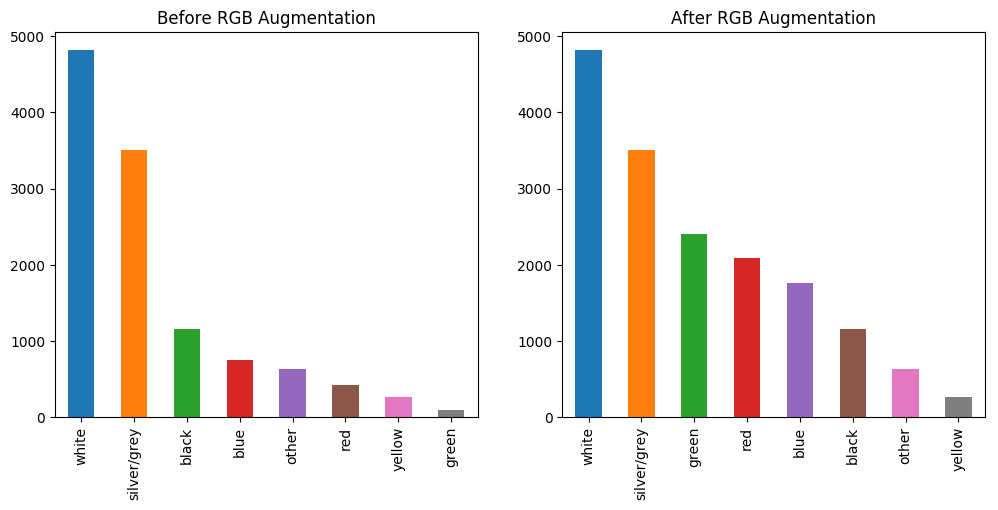

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

df['color'].value_counts().plot.bar(title='Before RGB Augmentation', ax=ax[0])
Y_train_aug_rgb_df.sum().sort_values(ascending=False).plot.bar(title='After RGB Augmentation', ax=ax[1])

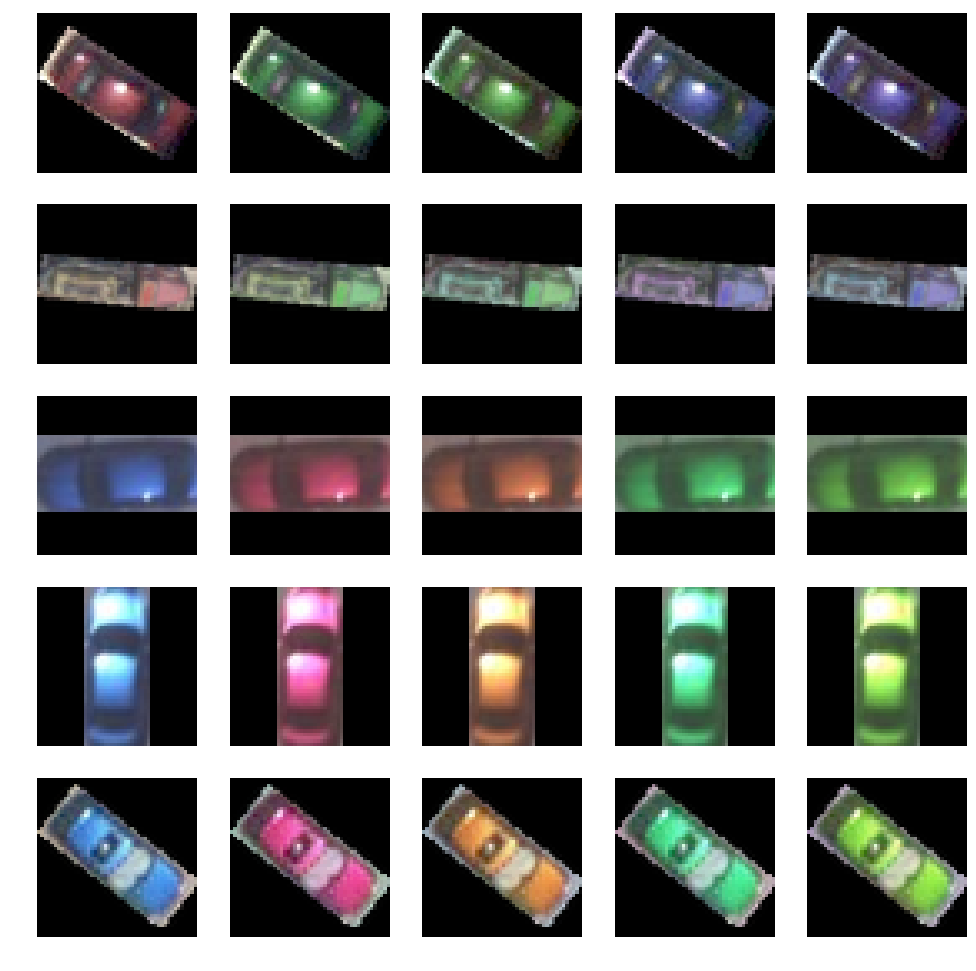

In [0]:
indices_to_plot = [6, 12, 10009, 1213, 15008]
fig, ax = plt.subplots(len(indices_to_plot), 5, figsize=(12, 12))
for i, k in enumerate(indices_to_plot):
  for j in range(5):
    ax[i, j].imshow(X_train_aug_rgb[k + j])
    ax[i, j].axis('off')

### Basic Tensorflow Augmentation

In [0]:
def augment_flip(image, label):
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_flip_left_right(image)
  return image, label

In [0]:
def augment_color_adj(image, label):
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, lower=0.2, upper=0.8)
  image = tf.clip_by_value(image, clip_value_min=-1.0, clip_value_max=1.0)
  return image, label

In [0]:
def augment(image, label):
  image, label = augment_flip(image, label)
  image, label = augment_color_adj(image, label)
  return image, label

Instructions for updating:
Colocations handled automatically by placer.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Random Color Adjustment')

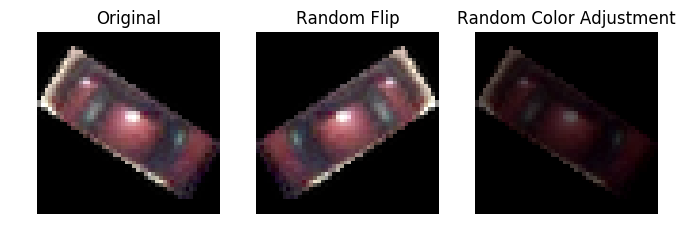

In [0]:
funcs = [augment_flip, augment_color_adj]
img_to_display = X_train_black[2]
adjs_imgs = [f(img_to_display, None)[0] for f in funcs]

with tf.Session() as sess:
  im = sess.run(adjs_imgs)

fig, ax = plt.subplots(ncols=3, figsize=(8, 5))
ax[0].imshow(img_to_display)
ax[0].axis('off')
ax[0].set_title('Original')
ax[1].imshow(im[0])
ax[1].axis('off')
ax[1].set_title('Random Flip')
ax[2].imshow(im[1])
ax[2].axis('off')
ax[2].set_title('Random Color Adjustment')

# Color Classification

* We chose to focus first on color prediction, because we can use some non-trivial methods to improve the results.
* We start off by examining known neural network architectures.
* Color data is transformed via One-Hot encoding.
* At this part, we measure the performance by splitting the train data to train and test, due to lack of labeled test data.

In [0]:
def predict_label(model, X_test, y_test):
  x = model.predict(X_test, batch_size=BATCH_SIZE)
  return pd.DataFrame({
      'prediction': y_test.columns[np.argmax(x, axis=1).astype(int)],
      'probability': np.max(x, axis=1).round(2),
      'label': y_test.idxmax(axis=1)
  })

In [0]:
# split (train) dataframe to test and train
np.random.seed(45)
msk = np.random.rand(len(df)) < 0.85

df_train = df[msk]
df_train.index = list(range(len(df_train)))

df_test = df[~msk]
df_test.index = list(range(len(df_test)))

In [0]:
# set training and test labels as one-hot data
Y_train_color = pd.get_dummies(df_train['color']).astype(np.float32)
y_test_color = pd.get_dummies(df_test['color']).astype(np.float32)
num_classes = Y_train_color.shape[1]

## Model definitions

We evaluate and compare the following models:
* [Multi-layer Perceptron](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py)
* [ConvNet](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py)
* [DeepCNN](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py)
* [BEER_NET](https://github.com/beerboaa/Color-Classification-CNN)


In [0]:
def MultiLayerPerceptron(input_shape, classes, name):
  inputs = layers.Input(shape=input_shape)
  x = layers.Dense(32, activation='relu')(inputs)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(classes, activation='softmax')(x)
  return tf.keras.models.Model(inputs, x, name=f'mlp_{name}')


def ConvNet(input_shape, classes, name):
  inputs = layers.Input(shape=input_shape)
  x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
  x = layers.Conv2D(64, (3, 3), activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.25)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(classes, activation='softmax')(x)
  return tf.keras.models.Model(inputs, x, name=f'convnet_{name}')


def DeepCNN(input_shape, classes, name):
  inputs = layers.Input(shape=input_shape)
  
  x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
  x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.25)(x)
  
  x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
  x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.25)(x)
  
  x = layers.Flatten()(x)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(classes, activation='softmax')(x)
  
  return tf.keras.models.Model(inputs, x, name=f'deepcnn_{name}')


def DeepCNN2(input_shape, classes, name):
  inputs = layers.Input(shape=input_shape)
  x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(inputs)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.6)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.6)(x)
  x = layers.Dense(classes, activation='softmax')(x)
  return tf.keras.models.Model(inputs, x, name=f'deepcnn2_{name}')

def beer_net(input_shape, classes, name):
  
  # placeholder for input image
  input_image = layers.Input(shape=input_shape)
  
  # ============================================= TOP BRANCH ===================================================
  # first top convolution layer
  top_conv1 = layers.Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                            input_shape=input_shape,activation='relu')(input_image)
  top_conv1 = layers.BatchNormalization()(top_conv1)
  top_conv1 = layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

  # second top convolution layer
  # split feature map by half
  top_top_conv2 = layers.Lambda(lambda x : x[:,:,:,:24])(top_conv1)
  top_bot_conv2 = layers.Lambda(lambda x : x[:,:,:,24:])(top_conv1)

  top_top_conv2 = layers.Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
  top_top_conv2 = layers.BatchNormalization()(top_top_conv2)
  top_top_conv2 = layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

  top_bot_conv2 = layers.Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
  top_bot_conv2 = layers.BatchNormalization()(top_bot_conv2)
  top_bot_conv2 = layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

  # third top convolution layer
  # concat 2 feature map
  top_conv3 = layers.Concatenate()([top_top_conv2,top_bot_conv2])
  top_conv3 = layers.Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)

  # fourth top convolution layer
  # split feature map by half
  top_top_conv4 = layers.Lambda(lambda x : x[:,:,:,:96])(top_conv3)
  top_bot_conv4 = layers.Lambda(lambda x : x[:,:,:,96:])(top_conv3)

  top_top_conv4 = layers.Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
  top_bot_conv4 = layers.Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

  # fifth top convolution layer
  top_top_conv5 = layers.Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
  top_top_conv5 = layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5) 

  top_bot_conv5 = layers.Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
  top_bot_conv5 = layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

  # ============================================= TOP BOTTOM ===================================================
  # first bottom convolution layer
  bottom_conv1 = layers.Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                            input_shape=(224,224,3),activation='relu')(input_image)
  bottom_conv1 = layers.BatchNormalization()(bottom_conv1)
  bottom_conv1 = layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

  # second bottom convolution layer
  # split feature map by half
  bottom_top_conv2 = layers.Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
  bottom_bot_conv2 = layers.Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

  bottom_top_conv2 = layers.Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
  bottom_top_conv2 = layers.BatchNormalization()(bottom_top_conv2)
  bottom_top_conv2 = layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

  bottom_bot_conv2 = layers.Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
  bottom_bot_conv2 = layers.BatchNormalization()(bottom_bot_conv2)
  bottom_bot_conv2 = layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

  # third bottom convolution layer
  # concat 2 feature map
  bottom_conv3 = layers.Concatenate()([bottom_top_conv2,bottom_bot_conv2])
  bottom_conv3 = layers.Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

  # fourth bottom convolution layer
  # split feature map by half
  bottom_top_conv4 = layers.Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
  bottom_bot_conv4 = layers.Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

  bottom_top_conv4 = layers.Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
  bottom_bot_conv4 = layers.Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

  # fifth bottom convolution layer
  bottom_top_conv5 = layers.Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
  bottom_top_conv5 = layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5) 

  bottom_bot_conv5 = layers.Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
  bottom_bot_conv5 = layers.MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

  # ======================================== layers.CONCATENATE TOP AND BOTTOM BRANCH =================================
  conv_output = layers.Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

  # Flatten
  flatten = layers.Flatten()(conv_output)

  # Fully-connected layer
  FC_1 = layers.Dense(units=4096, activation='relu')(flatten)
  FC_1 = layers.Dropout(0.6)(FC_1)
  FC_2 = layers.Dense(units=4096, activation='relu')(FC_1)
  FC_2 = layers.Dropout(0.6)(FC_2)
  output = layers.Dense(units=classes, activation='softmax')(FC_2)

  model = tf.keras.models.Model(inputs=input_image,outputs=output, name=f'BEER_NET_{name}')
  sgd = tf.keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [0]:
# load train and test images
images_train_path_split = df_train['tag_id'].map(lambda tag: f'cropped/{tag}.png')
images_test_path_split = df_test['tag_id'].map(lambda tag: f'cropped/{tag}.png')

X_train_color = load_images(images_train_path_split)
X_test_color = load_images(images_test_path_split)

# BEER_NET work with images larger than 48*48, so we use 80*80
BEER_SHAPE = (80, 80, 3)

X_train_color_80 = load_images(images_train_path_split, shape=BEER_SHAPE)
X_test_color_80 = load_images(images_test_path_split, shape=BEER_SHAPE)

In [0]:
# split train and validation 
X_train_color, X_val_color, y_train_color, y_val_color = train_test_split(X_train_color, Y_train_color.values, test_size=0.10, stratify=df_train['color'])
X_train_color_80, X_val_color_80, y_train_color_80, y_val_color_80 = train_test_split(X_train_color_80, Y_train_color.values, test_size=0.10, stratify=df_train['color'])

In [0]:
#nets parameters
steps_per_epoch=10
epochs=100
validation_steps=10

## Kick-off
* We don't limit epochs number, just let the models run.

In [0]:
for base_model in [MultiLayerPerceptron, ConvNet, DeepCNN, DeepCNN2]:
  model = base_model(IMG_SHAPE, num_classes, name='color1')
  csv_logger = tf.keras.callbacks.CSVLogger(f'models/{model.name}.csv')
  model = to_tpu_model(model)
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  model.fit(input_fn(X_train_color, y_train_color),
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=[csv_logger],
            validation_data=input_fn(X_val_color, y_val_color),
            validation_steps=validation_steps)
  model.save(f'models/{model.name}.h5')

In [0]:
# special case for beer_net, as it's already a compiled model
model = beer_net(BEER_SHAPE, num_classes, name='color1')
csv_logger = tf.keras.callbacks.CSVLogger(f'models/{model.name}.csv')
model = to_tpu_model(model)
model.fit(input_fn(X_train_color_80, y_train_color_80),
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          callbacks=[csv_logger],
          validation_data=input_fn(X_val_color_80, y_val_color_80),
          validation_steps=validation_steps)
model.save(f'models/{model.name}.h5')

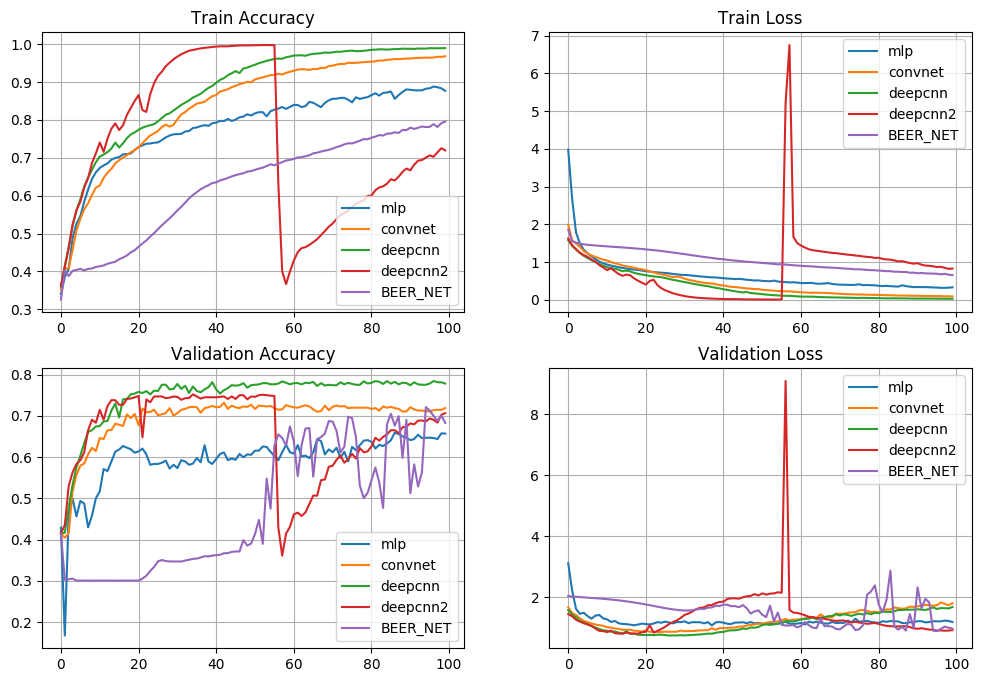

In [0]:
names = ['mlp', 'convnet', 'deepcnn', 'deepcnn2', 'BEER_NET']
dfs = [pd.read_csv(f'models/{name}_color1.csv') for name in names]

train_acc = pd.concat([df.acc.rename(name) for name, df in zip(names, dfs)], axis=1)
train_loss = pd.concat([df.loss.rename(name) for name, df in zip(names, dfs)], axis=1)
validation_acc = pd.concat([df.val_acc.rename(name) for name, df in zip(names, dfs)], axis=1)
validation_loss = pd.concat([df.val_loss.rename(name) for name, df in zip(names, dfs)], axis=1)

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
train_acc.plot(title="Train Accuracy", ax=ax[0, 0], grid=True)
train_loss.plot(title="Train Loss", ax=ax[0, 1], grid=True)
validation_acc.plot(title="Validation Accuracy", ax=ax[1, 0], grid=True)
validation_loss.plot(title="Validation Loss", ax=ax[1, 1], grid=True)

**Conclusions:**
* The simpler models convergence at smaller epoch's step number.
* These models overfitted the data, so we should stop their training earlier. We will handle this with early stopping functions.

**Early Stopping :**

* Early stopping is a callback function which stop the training if specified conditions were met.
* This method helps to prevent data overfitting and prevent exploding/vanishing gradient.
* In our case (after tuning), we stop the training if the validation accuracy doesn't improve by 0.02 after 15 epochs **and** if validation accuracy greater than 0.7.

In [0]:
class MyEarlyStopping(tf.keras.callbacks.EarlyStopping):
  
  def __init__(self, minimum_target=None, **kwargs):
    self.minimum_target = minimum_target
    super(MyEarlyStopping, self).__init__(**kwargs)
    self.monitor_op = np.greater # define the op we need (for accuracy we use greater, for loss we use less)

  def on_epoch_end(self, epoch, logs):
    current = logs.get(self.monitor)
    if self.minimum_target and self.monitor_op(current, self.minimum_target):
          super(MyEarlyStopping, self).on_epoch_end(epoch, logs)

        
es = MyEarlyStopping(monitor='val_acc',
                     min_delta=0.02,
                     patience=15, # define how many epochs, without 'min_delta' improvement, until early stopping.
                     verbose=1,
                     mode='auto',
                     baseline=None,
                     minimum_target=0.7)

In [0]:
for base_model in [MultiLayerPerceptron, ConvNet, DeepCNN, DeepCNN2]:
  model = base_model(IMG_SHAPE, num_classes, name='es_color1')
  csv_logger = tf.keras.callbacks.CSVLogger(f'models/{model.name}.csv')
  model = to_tpu_model(model)
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  model.fit(input_fn(X_train_color, y_train_color),
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=[csv_logger, es], # We define the early stopping as a callback.
            validation_data=input_fn(X_val_color, y_val_color),
            validation_steps=validation_steps)
  model.save(f'models/{model.name}.h5')

In [0]:
# special case for beer_net, as it's already a compiled model
model = beer_net(BEER_SHAPE, num_classes, name='es_color1')
csv_logger = tf.keras.callbacks.CSVLogger(f'models/{model.name}.csv')
model = to_tpu_model(model)
model.fit(input_fn(X_train_color_80, y_train_color_80),
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          callbacks=[csv_logger, es],
          validation_data=input_fn(X_val_color_80, y_val_color_80),
          validation_steps=validation_steps)
model.save(f'models/{model.name}.h5')

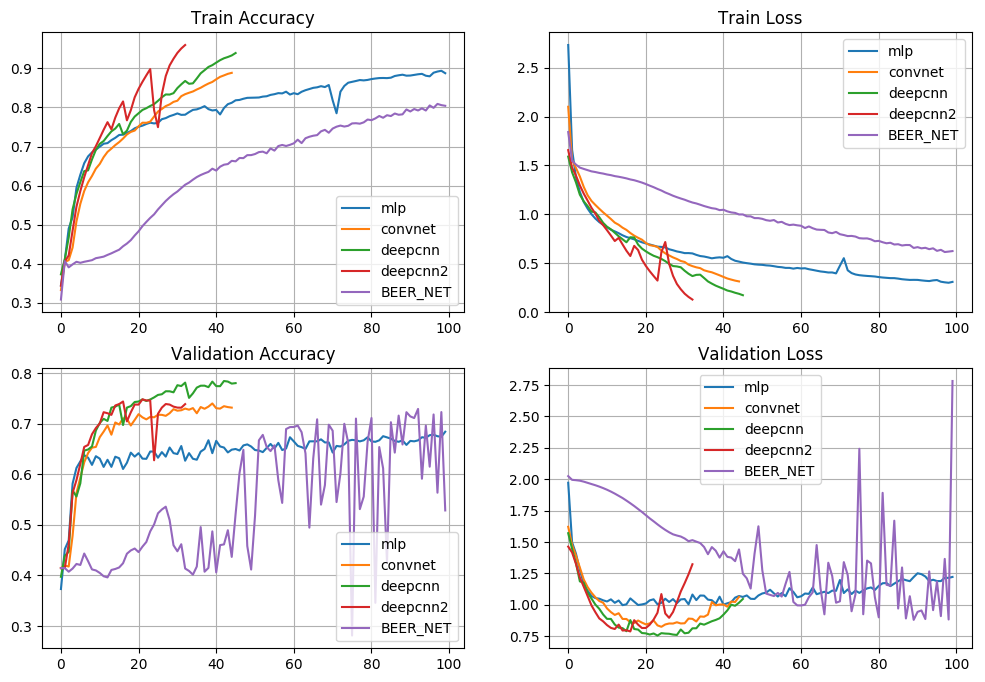

In [0]:
names = ['mlp', 'convnet', 'deepcnn', 'deepcnn2', 'BEER_NET']
dfs = [pd.read_csv(f'models/{name}_es_color1.csv') for name in names]

train_acc = pd.concat([df.acc.rename(name) for name, df in zip(names, dfs)], axis=1)
train_loss = pd.concat([df.loss.rename(name) for name, df in zip(names, dfs)], axis=1)
validation_acc = pd.concat([df.val_acc.rename(name) for name, df in zip(names, dfs)], axis=1)
validation_loss = pd.concat([df.val_loss.rename(name) for name, df in zip(names, dfs)], axis=1)

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
train_acc.plot(title="Train Accuracy", ax=ax[0, 0], grid=True)
train_loss.plot(title="Train Loss", ax=ax[0, 1], grid=True)
validation_acc.plot(title="Validation Accuracy", ax=ax[1, 0], grid=True)
validation_loss.plot(title="Validation Loss", ax=ax[1, 1], grid=True)

In [0]:
results = []
for name in names:
  model = tf.keras.models.load_model(f'models/{name}_es_color1.h5')
  if name != "BEER_NET":
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    results.append(predict_label(model, X_test_color, y_test_color))
  else:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    results.append(predict_label(model, X_test_color_80, y_test_color))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


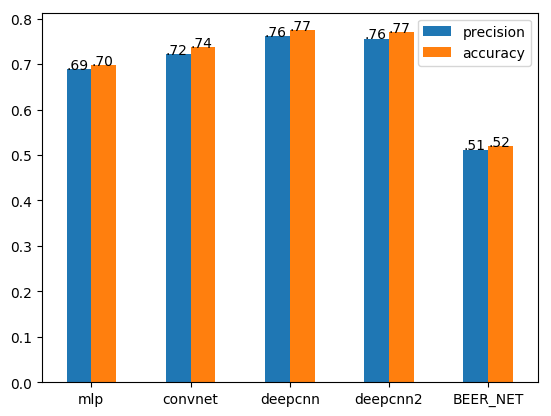

In [0]:
df_results = pd.DataFrame([precision_score(result['label'], result['prediction'], average='weighted')
                           for name,result
                           in zip(names,results)], columns=['precision'],
                          index=names)
df_results['accuracy'] = pd.Series([accuracy_score(result['label'], result['prediction'])
                                    for name,result
                                    in zip(names,results)],
                                   index=names)
ax = df_results.plot(kind='bar', rot=0)
for p in ax.patches:
  ax.annotate(f"{p.get_height():.2f}"[1:], (p.get_x(), p.get_height()))

**Conclusions:**
* `DeepCnn` is better than the others, as we can see in the validations plots and in the accuracy&precision plot.
* `Beer_Net` and `MultiLayerPerceptron` are very noisy and takes more epochs for convergence, we will try to improve it's training.
* `MultiLayerPerceptron` is struggling fit the data in comparison to the other (convolutional) models, we won't try to improve it anymore.

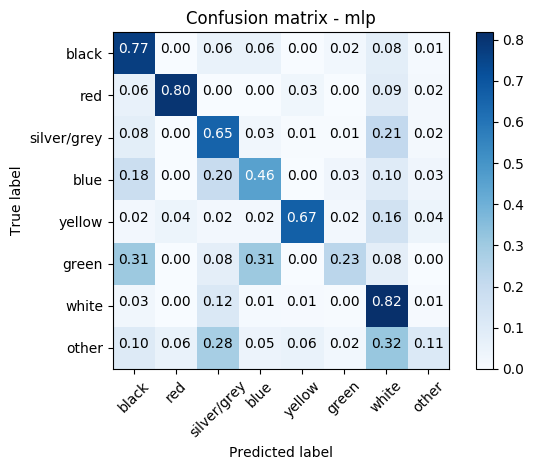

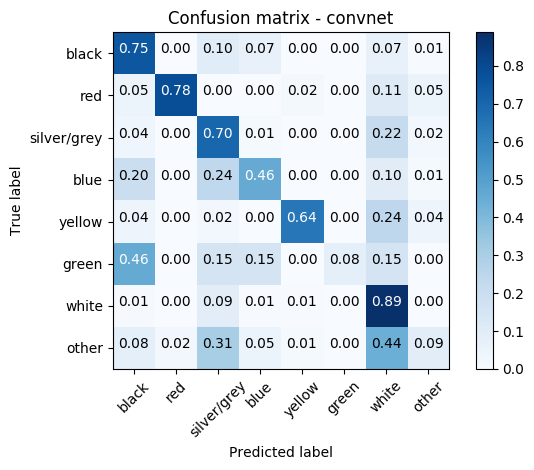

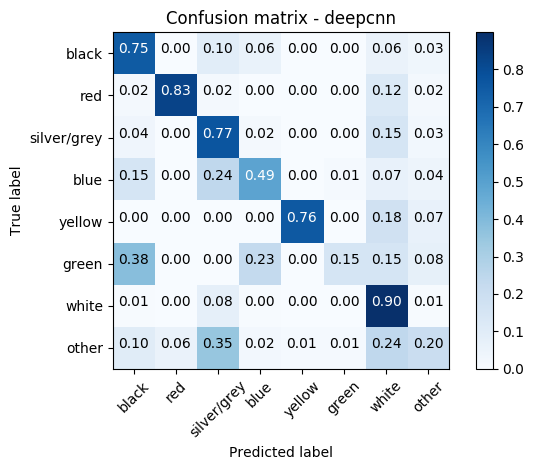

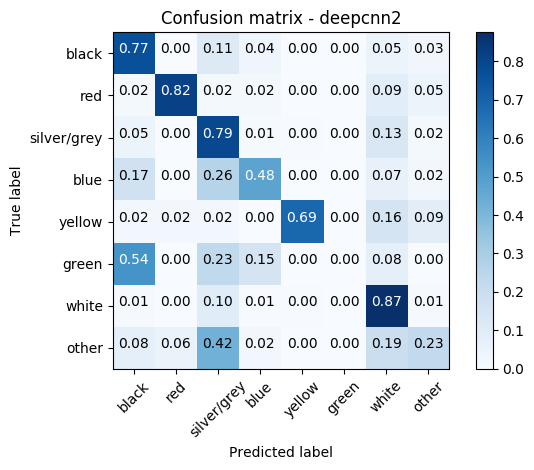

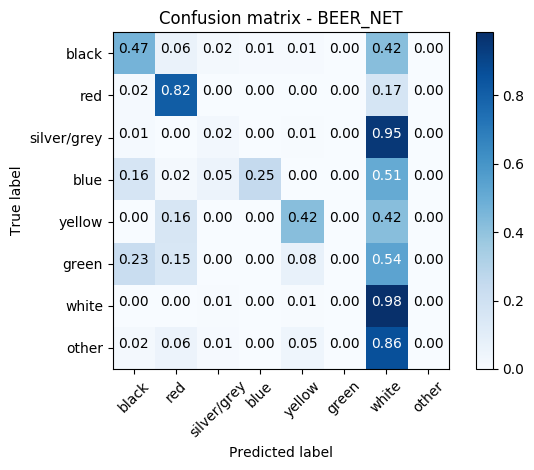

In [0]:
for name in names:
  colors = df.color.unique().tolist()
  result1 = results[names.index(name)].copy()
  for col in ['label', 'prediction']:
    result1[col] = results[names.index(name)][col].map({j:i for i,j in zip(range(len(colors)), colors)})

  cnf_matrix = confusion_matrix(result1['label'], result1['prediction'])
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=colors, normalize=True,
                        title=f'Confusion matrix - {name}')

As we can see in the confusion matrix, there are three main difficulties:
* There are `white` & `silver/grey` mislabeling (both flase positives and true negatives) as expected due to the similarity (see next plot).
* `Green` predictions isn't good (false negative).
* `Other` predictions is difficult.

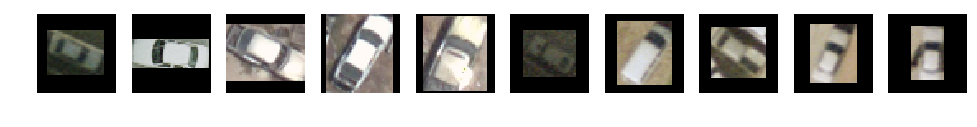

In [0]:
indices_to_plot = [74, 90, 11597, 11599, 11606, 227, 229, 231, 392, 427]
fig, ax = plt.subplots(1, len(indices_to_plot), figsize=(12, 12))
for i, k in enumerate(indices_to_plot):
  image = load_image(images_train_path[k], IMG_SHAPE, keep_ratio=True)
  ax[i].imshow(image)
  ax[i].axis('off')

## Basic Augmentation

* We add basic augmentation (flips, rotations, brightness, contrast).
* We define new early stopping, according to previous results - separate for different models.
 
 

In [0]:
steps_per_epoch=10
epochs=200
validation_steps=10

class ConvNetEarlyStopping(tf.keras.callbacks.EarlyStopping):
  def __init__(self, minimum_target=None, **kwargs):
    self.minimum_target = minimum_target
    super(ConvNetEarlyStopping, self).__init__(**kwargs)
    self.monitor_op = np.less

  def on_epoch_end(self, epoch, logs):
    current = logs.get(self.monitor)
    if self.minimum_target and self.monitor_op(current, self.minimum_target):
      super(ConvNetEarlyStopping, self).on_epoch_end(epoch, logs)

        
ConvNetPes = ConvNetEarlyStopping(monitor='val_loss',
                                  min_delta=0.01,
                                  patience=10,
                                  verbose=1,
                                  mode='auto',
                                  baseline=None,
                                  minimum_target=0.9)


class DeepCNNEarlyStopping(tf.keras.callbacks.EarlyStopping):
  def __init__(self, minimum_target=None, **kwargs):
    self.minimum_target = minimum_target
    super(DeepCNNEarlyStopping, self).__init__(**kwargs)
    self.monitor_op = np.greater

  def on_epoch_end(self, epoch, logs):
    current = logs.get(self.monitor)
    if self.minimum_target and self.monitor_op(current, self.minimum_target):
      super(DeepCNNEarlyStopping, self).on_epoch_end(epoch, logs)

        
DeepCNNes = DeepCNNEarlyStopping(monitor='val_acc',
                                 min_delta=0.01,
                                 patience=10,
                                 verbose=1,
                                 mode='auto',
                                 baseline=None,
                                 minimum_target=0.75)


class DeepCNN2EarlyStopping(tf.keras.callbacks.EarlyStopping):
  
  def __init__(self, minimum_target=None, **kwargs):
    self.minimum_target = minimum_target
    super(DeepCNN2EarlyStopping, self).__init__(**kwargs)
    self.monitor_op = np.greater

  def on_epoch_end(self, epoch, logs):
    current = logs.get(self.monitor)
    if self.minimum_target and self.monitor_op(current, self.minimum_target):
      super(DeepCNN2EarlyStopping, self).on_epoch_end(epoch, logs)

      
DeepCNN2es = DeepCNN2EarlyStopping(monitor='val_acc',
                                 min_delta=0.01,
                                 patience=10,
                                 verbose=1,
                                 mode='auto',
                                 baseline=None,
                                 minimum_target=0.75)


class BeerNetEarlyStopping(tf.keras.callbacks.EarlyStopping):
  
  def __init__(self, minimum_target=None, **kwargs):
    self.minimum_target = minimum_target
    super(BeerNetEarlyStopping, self).__init__(**kwargs)
    self.monitor_op = np.greater

  def on_epoch_end(self, epoch, logs):
    current = logs.get(self.monitor)
    if self.minimum_target and self.monitor_op(current, self.minimum_target):
      super(BeerNetEarlyStopping, self).on_epoch_end(epoch, logs)

      
BeerNetes = BeerNetEarlyStopping(monitor='val_acc',
                                 min_delta=0.01,
                                 patience=15,
                                 verbose=1,
                                 mode='auto',
                                 baseline=None,
                                 minimum_target=0.7)


earlyStoppers = {ConvNet:ConvNetPes, DeepCNN:DeepCNNes, DeepCNN2:DeepCNN2es, beer_net:BeerNetes}

In [0]:
for base_model in [ConvNet, DeepCNN, DeepCNN2]:
  model = base_model(IMG_SHAPE, num_classes, name='color2')
  csv_logger = tf.keras.callbacks.CSVLogger(f'models/{model.name}.csv')
  model = to_tpu_model(model)
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  model.fit(input_fn(X_train_color, y_train_color, augment_fn=augment), # the augmentation perform through the input_fn
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=[csv_logger, earlyStoppers[base_model]], # different early stopping.
            validation_data=input_fn(X_val_color, y_val_color, augment_fn=augment),
            validation_steps=validation_steps)
  model.save(f'models/{model.name}.h5')

In [0]:
base_model = beer_net
model = base_model(BEER_SHAPE, num_classes, name='color2')
csv_logger = tf.keras.callbacks.CSVLogger(f'models/{model.name}.csv')
model = to_tpu_model(model)
model.fit(input_fn(X_train_color_80, y_train_color_80, augment_fn=augment),
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          callbacks=[csv_logger, earlyStoppers[base_model]],
          validation_data=input_fn(X_val_color_80, y_val_color_80, augment_fn=augment),
          validation_steps=validation_steps)
model.save(f'models/{model.name}.h5')

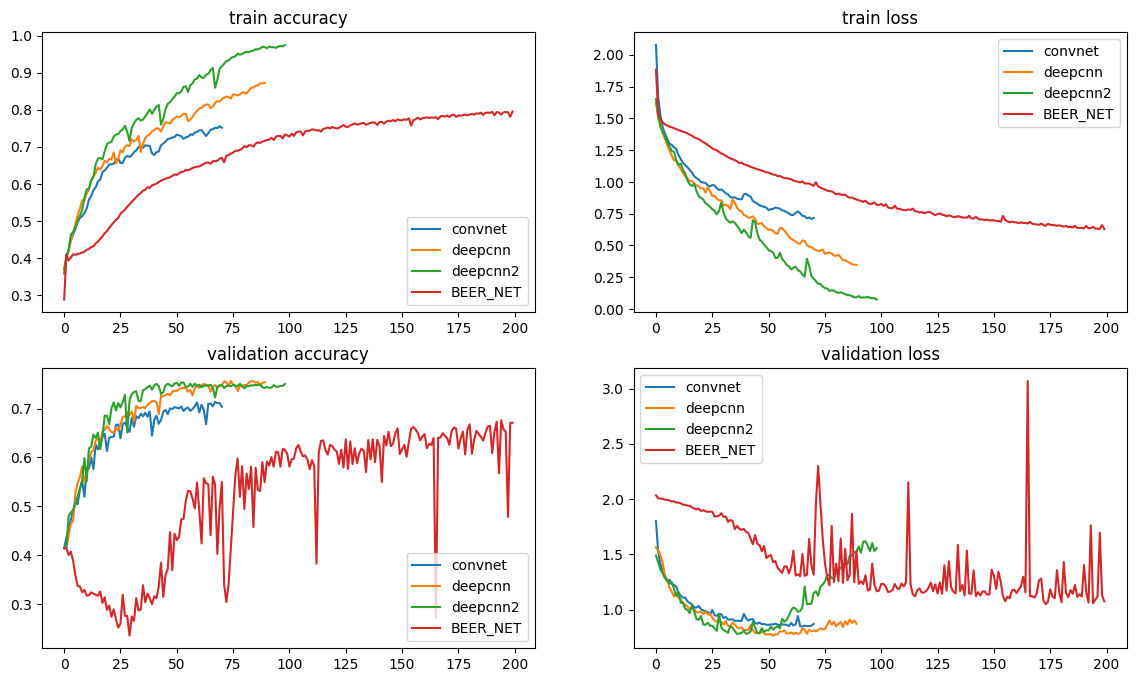

In [0]:
names = ['convnet', 'deepcnn', 'deepcnn2','BEER_NET']
dfs = [pd.read_csv(f'models/{name}_color2.csv') for name in names]

train_acc = pd.concat([df.acc.rename(name) for name, df in zip(names, dfs)], axis=1)
train_loss = pd.concat([df.loss.rename(name) for name, df in zip(names, dfs)], axis=1)
validation_acc = pd.concat([df.val_acc.rename(name) for name, df in zip(names, dfs)], axis=1)
validation_loss = pd.concat([df.val_loss.rename(name) for name, df in zip(names, dfs)], axis=1)


fig, ax = plt.subplots(2, 2, figsize=(14, 8))
train_acc.plot(title="train accuracy", ax=ax[0,0])
train_loss.plot(title="train loss", ax=ax[0,1])
validation_acc.plot(title="validation accuracy", ax=ax[1,0])
validation_loss.plot(title="validation loss", ax=ax[1,1])

In [0]:
results = []
for name in names:
  model = tf.keras.models.load_model(f'models/{name}_color2.h5')
  if name != "BEER_NET":
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    results.append(predict_label(model, X_test_color, y_test_color))
  else:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    results.append(predict_label(model, X_test_color_80, y_test_color))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


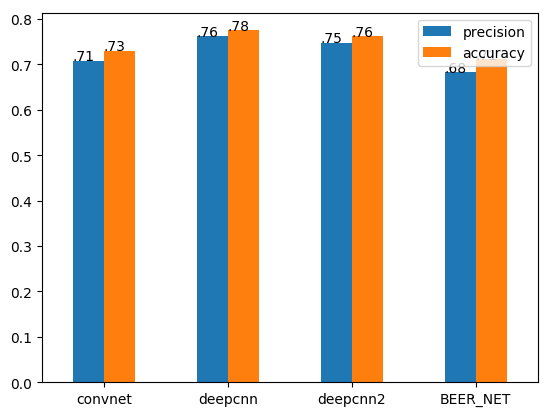

In [0]:
df_results = pd.DataFrame([precision_score(result['label'], result['prediction'], average='weighted') for name,result in zip(names,results)], columns=["precision"], index = names)
df_results["accuracy"] = pd.Series([accuracy_score(result['label'], result['prediction']) for name,result in zip(names,results)], index = names)
ax = df_results.plot(kind="bar",rot=0)
for p in ax.patches:
  ax.annotate(f"{p.get_height():.2f}"[1:], (p.get_x(), p.get_height()))
  

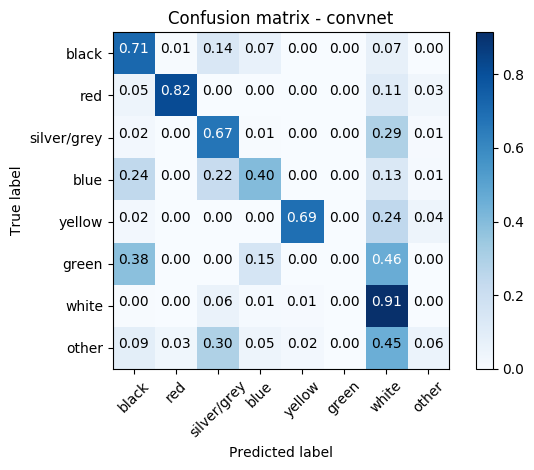

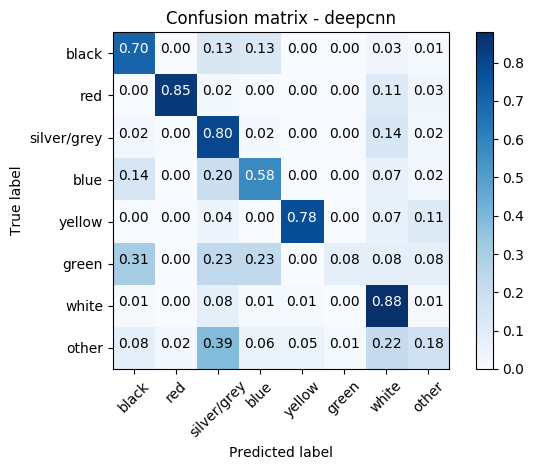

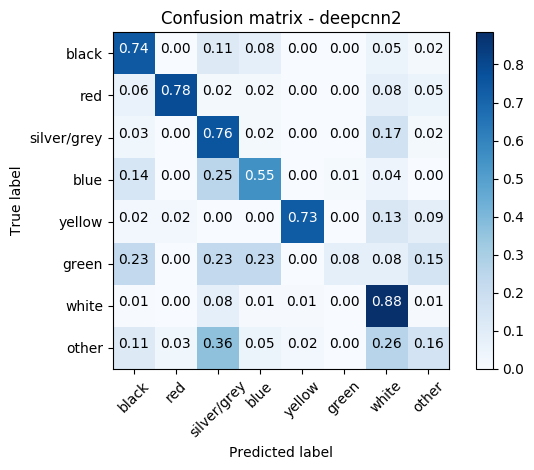

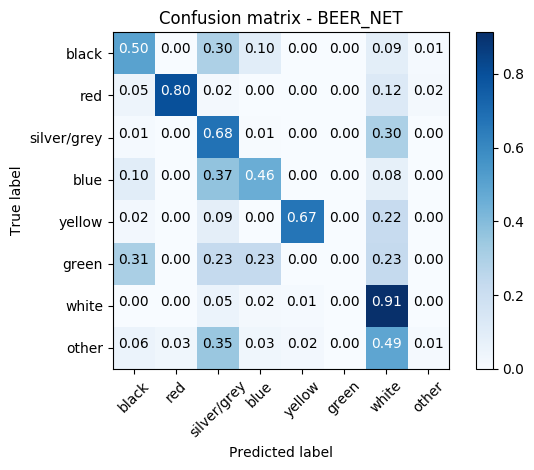

In [0]:
for name in names:
  colors = df.color.unique().tolist()
  result1 = results[names.index(name)].copy()
  for col in ['label','prediction']:
    result1[col] = results[names.index(name)][col].map({j:i for i,j in zip(range(len(colors)), colors)})

  cnf_matrix = confusion_matrix(result1['label'], result1['prediction'])
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=colors, normalize=True,
                        title=f'Confusion matrix - {name}')

**Conclusions:**
* `DeepCNN` and `DeepCNN2` are the winners here.
* `BeerNet` it too noisy, even after tuning. It performs better on traffic camera pictures (the architecture original goal).

We will continue with `DeepCNN` & `DeepCNN2` models, add some complex augmentation and finish tuning the algorithms.

##Weigthed models

* We add different weight to classes, in order to improve class imbalance issues.

In [0]:
# define balanced weights (according to class size's)
x = Y_train_color.sum(axis=0)
class_weights = dict(enumerate(x.sum() / x))
class_weights

{0: 10.059002876281738,
 1: 15.212307929992676,
 2: 117.71428680419922,
 3: 18.379182815551758,
 4: 28.332378387451172,
 5: 3.327052593231201,
 6: 2.4122955799102783,
 7: 46.42253494262695}

In [0]:
# use all of train data here, with no validation. We hard-coded #epochs at this training (no early stopping).
class MyEarlyStopping(tf.keras.callbacks.EarlyStopping):
  
  def __init__(self, minimum_target=None, **kwargs):
    self.minimum_target = minimum_target
    super(MyEarlyStopping, self).__init__(**kwargs)
    self.monitor_op = np.greater # define the op we need (for accuracy we use greater, for loss we use less)

  def on_epoch_end(self, epoch, logs):
    current = logs.get(self.monitor)
    if self.minimum_target and self.monitor_op(current, self.minimum_target):
          super(MyEarlyStopping, self).on_epoch_end(epoch, logs)

        
es = MyEarlyStopping(monitor='acc',
                     min_delta=0.02,
                     patience=10, # define how many epochs, without 'min_delta' improvement, until early stopping.
                     verbose=1,
                     mode='auto',
                     baseline=None,
                     minimum_target=0.85)

In [0]:
for base_model in [DeepCNN, DeepCNN2]:
  model = base_model(IMG_SHAPE, num_classes, name='color3')
  csv_logger = tf.keras.callbacks.CSVLogger(f'models/{model.name}.csv')
  model = to_tpu_model(model)
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  model.fit(input_fn(np.concatenate((X_train_color,X_val_color)), np.concatenate((y_train_color,y_val_color)), augment_fn=augment),
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=[csv_logger, es],
            class_weight=class_weights) #using class weights)
  model.save(f'models/{model.name}.h5')

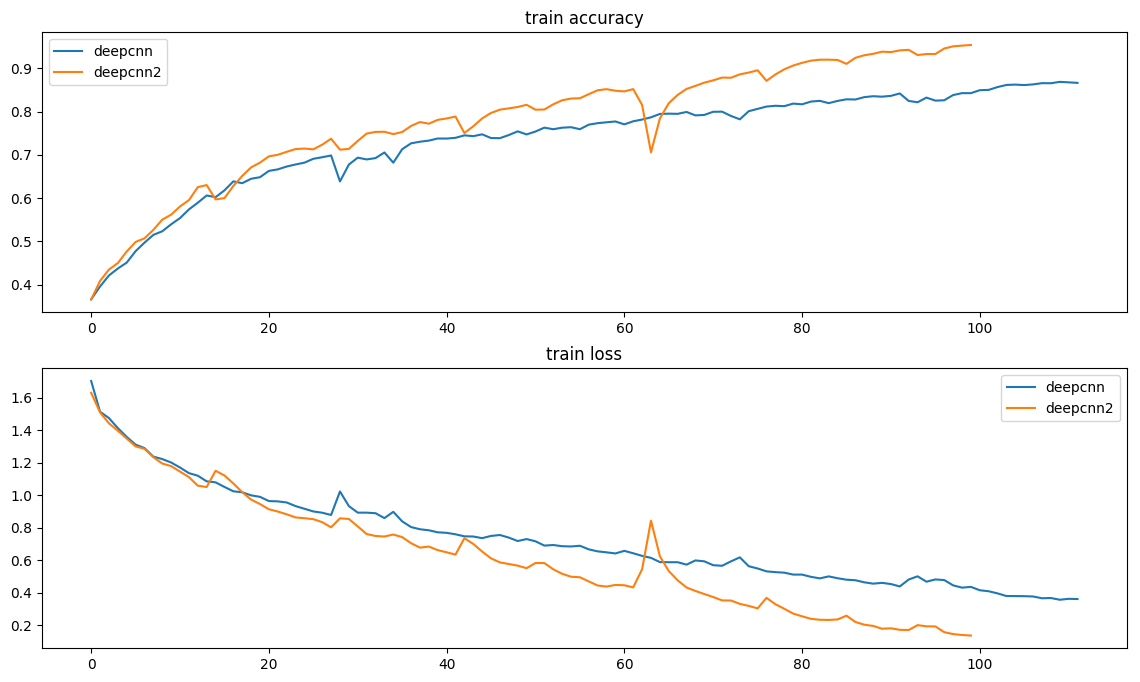

In [0]:
names = ['deepcnn', 'deepcnn2']
dfs = [pd.read_csv(f'models/{name}_color3.csv') for name in names]

train_acc = pd.concat([df.acc.rename(name) for name, df in zip(names, dfs)], axis=1)
train_loss = pd.concat([df.loss.rename(name) for name, df in zip(names, dfs)], axis=1)

fig, ax = plt.subplots(2, figsize=(14, 8))
train_acc.plot(title="train accuracy", ax=ax[0])
train_loss.plot(title="train loss", ax=ax[1])

In [0]:
results = []
for name in names:
  model = tf.keras.models.load_model(f'models/{name}_color3.h5')
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  results.append(predict_label(model, X_test_color, y_test_color))

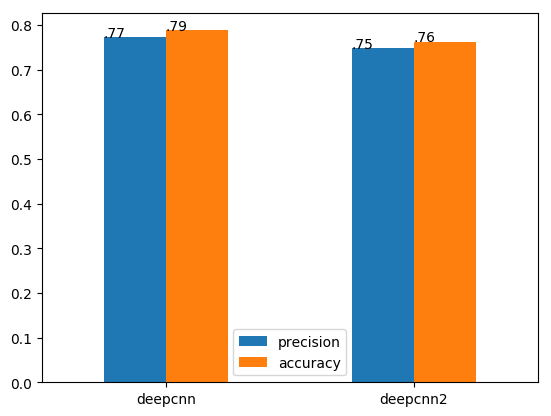

In [0]:
df_results = pd.DataFrame([precision_score(result['label'], result['prediction'], average='weighted') for name,result in zip(names,results)], columns=["precision"], index = names)
df_results["accuracy"] = pd.Series([accuracy_score(result['label'], result['prediction']) for name,result in zip(names,results)], index = names)
ax = df_results.plot(kind="bar",rot=0)
for p in ax.patches:
  ax.annotate(f"{p.get_height():.2f}"[1:], (p.get_x(), p.get_height()))

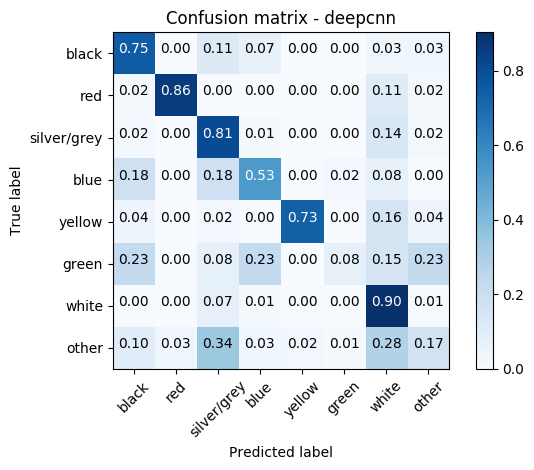

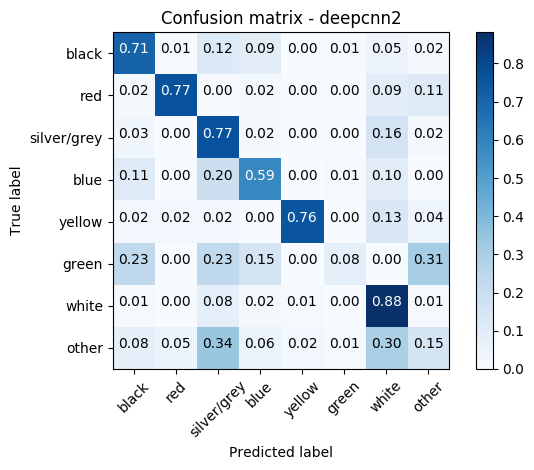

In [0]:
for name in names:
  colors = df.color.unique().tolist()
  result1 = results[names.index(name)].copy()
  for col in ['label','prediction']:
    result1[col] = results[names.index(name)][col].map({j:i for i,j in zip(range(len(colors)), colors)})

  cnf_matrix = confusion_matrix(result1['label'], result1['prediction'])
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=colors, normalize=True,
                        title=f'Confusion matrix - {name}')

##RGB Augmentation

* We use rgb augmentation, with the basic augmentation from the previous part.
* We expect to see imrovement in RGB colors prediction.

In [0]:
images_rgb_train_path = df_train['tag_id'].map(lambda tag: f'cropped/{tag}.png')
images_rgb_test_path = df_test['tag_id'].map(lambda tag: f'cropped/{tag}.png')

X_train_rgb, Y_train_rgb, df_rgb_train = get_rgb_augmented_images(df_train,
                                                                  images_rgb_train_path,
                                                                  IMG_SHAPE,
                                                                  keep_ratio=False)
y_train_rgb = Y_train_rgb.values.astype(np.float32)

In [0]:
steps_per_epoch=10
epochs=140
validation_steps=10

class MyEarlyStopping(tf.keras.callbacks.EarlyStopping):
  
  def __init__(self, minimum_target=None, **kwargs):
    self.minimum_target = minimum_target
    super(MyEarlyStopping, self).__init__(**kwargs)
    self.monitor_op = np.greater 

  def on_epoch_end(self, epoch, logs):
    current = logs.get(self.monitor)
    if self.minimum_target and self.monitor_op(current, self.minimum_target):
          super(MyEarlyStopping, self).on_epoch_end(epoch, logs)

        
es = MyEarlyStopping(monitor='acc',
                     min_delta=0.01,
                     patience=10, 
                     verbose=1,
                     mode='auto',
                     baseline=None,
                     minimum_target=0.8)

In [0]:
# we don't use validation in this part of training in order to use all of the data.

for base_model in [DeepCNN, DeepCNN2]:
  model = base_model(IMG_SHAPE, num_classes, name='color4')
  csv_logger = tf.keras.callbacks.CSVLogger(f'models/{model.name}.csv')
  model = to_tpu_model(model)
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  train_input_fn = input_fn(X_train_rgb, y_train_rgb, augment_fn=augment)
  model.fit(train_input_fn,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=[csv_logger, es])
  model.save(f'models/{model.name}.h5')

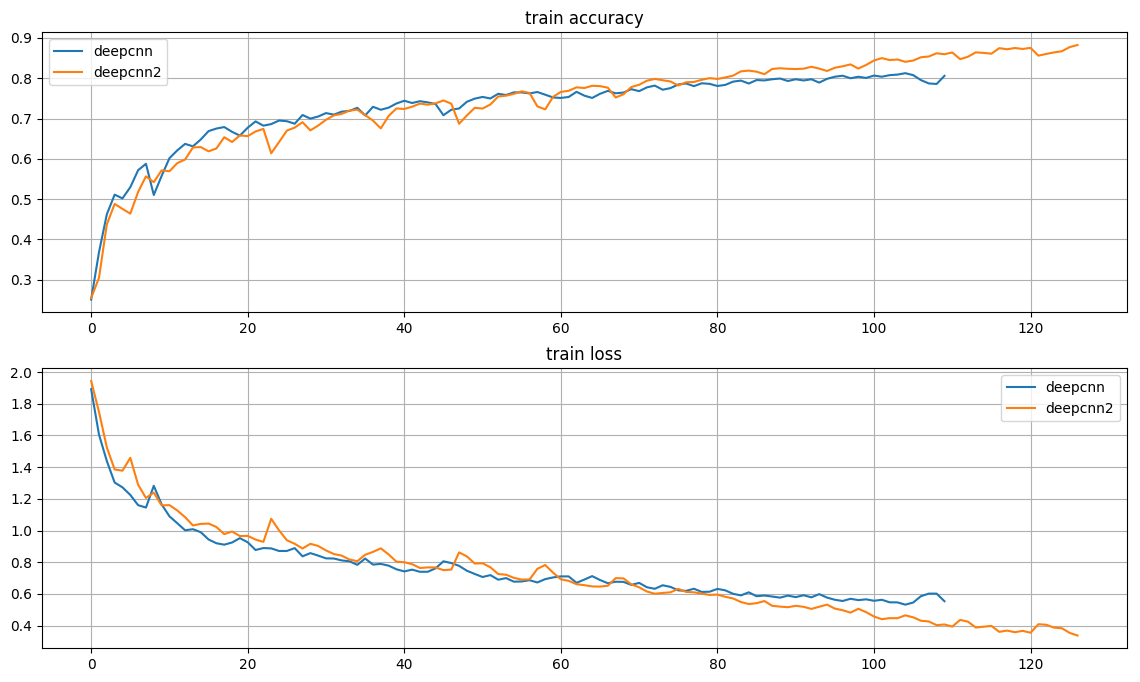

In [0]:
names = ['deepcnn', 'deepcnn2']
dfs = [pd.read_csv(f'models/{name}_color4.csv') for name in names]

train_acc = pd.concat([df.acc.rename(name) for name, df in zip(names, dfs)], axis=1)
train_loss = pd.concat([df.loss.rename(name) for name, df in zip(names, dfs)], axis=1)

fig, ax = plt.subplots(2, figsize=(14, 8))
train_acc.plot(title="train accuracy", ax=ax[0], grid=True)
train_loss.plot(title="train loss", ax=ax[1], grid=True)

In [0]:
results = []
for name in names:
  model = tf.keras.models.load_model(f'models/{name}_color4.h5')
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  results.append(predict_label(model, X_test_color, y_test_color))

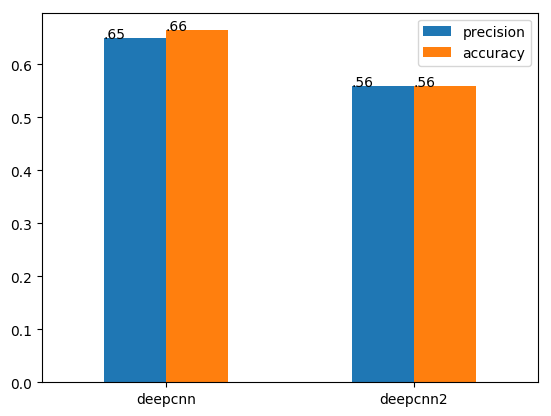

In [0]:
df_results = pd.DataFrame([precision_score(result['label'], result['prediction'], average='weighted')
                           for name, result
                           in zip(names,results)], columns=["precision"],
                          index=names)
df_results["accuracy"] = pd.Series([accuracy_score(result['label'], result['prediction'])
                                    for name, result
                                    in zip(names,results)],
                                   index=names)
ax = df_results.plot(kind="bar", rot=0)
for p in ax.patches:
  ax.annotate(f"{p.get_height():.2f}"[1:], (p.get_x(), p.get_height()))

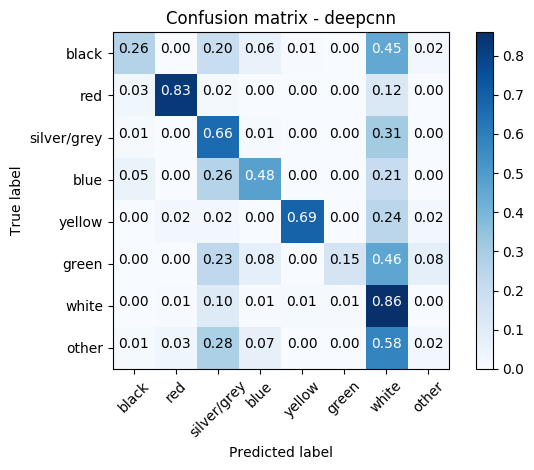

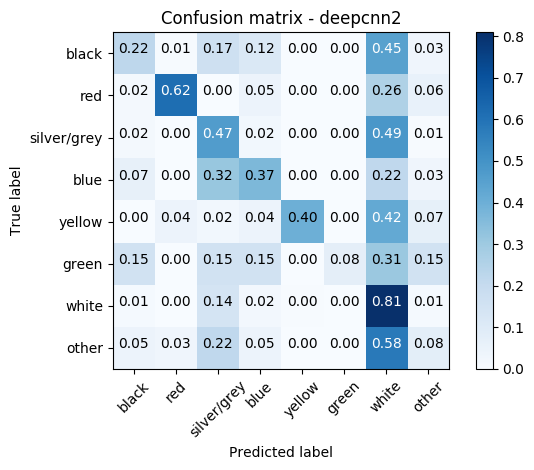

In [0]:
for name in names:
  colors = df.color.unique().tolist()
  result1 = results[names.index(name)].copy()
  for col in ['label','prediction']:
    result1[col] = results[names.index(name)][col].map({j : i for i, j in zip(range(len(colors)), colors)})
  cnf_matrix = confusion_matrix(result1['label'], result1['prediction'])
  plt.figure()
  plot_confusion_matrix(cnf_matrix,
                        classes=colors,
                        normalize=True,
                        title=f'Confusion matrix - {name}')

##Ensemble

In [0]:
def AverageEnsemble(models, input_shape):
  input_layer = layers.Input(shape=input_shape)
  x = tf.keras.layers.Average()([model(input_layer) for model in models])
  model = tf.keras.models.Model(input_layer, x, name='my-ensemble')
  return model

names = ['deepcnn','deepcnn2']
models = [tf.keras.models.load_model(f'models/{name}_color4.h5') for name in names]
model = AverageEnsemble(models, input_shape=X_train.shape[1:])

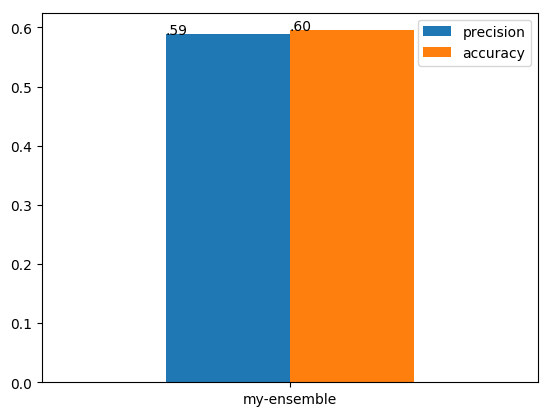

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
results = [predict_label(model, X_test_color, y_test_color)]
  
df_results = pd.DataFrame([precision_score(result['label'], result['prediction'], average='weighted') for name,result in zip(['my-ensemble'],results)], columns=["precision"], index = ['my-ensemble'])
df_results["accuracy"] = pd.Series([accuracy_score(result['label'], result['prediction']) for name,result in zip(['my-ensemble'],results)], index = ['my-ensemble'])
ax = df_results.plot(kind="bar",rot=0)
for p in ax.patches:
  ax.annotate(f"{p.get_height():.2f}"[1:], (p.get_x(), p.get_height()))

# One Model to Rule Them All

* The compatition major usage scenario is one that deals with **retrieval**.
* A user wishes to retrieve, let's say, orange sedans with a sunroof. His expectation is that the module will come up with the best matches for the retrieval criteria. The user, therefore, defines the query (desired classes, sub-classes, features and colors) and the module should provide the best results, ranked.
* It is very different from the standard "classification" problem framing, where each object should be classified and labeled optimally and independently of the other objects. Thus, the challenge deals with **ranking**, not only classification/labeling.

**The Takeout**:
* We generate a 37 size one-hot labels vector for each object.
* We treat all these labels as **uncorrelated** and use binary cross-entropy loss for each of the labels.
* We focus on one model for the whole prediction process.
* We use *sigmoid* as our final activation layer for the final predictions (because we are interested in ranking).
* We do not use validation set during traning due to lack of enough instances with specific features.
* We do use the contest's test and and the online grader tool provided.

In [0]:
classes_names = ['general_class', 'sub_class', 'color']
features_names = ['sunroof', 'luggage_carrier', 'open_cargo_area',
                  'enclosed_cab', 'spare_wheel', 'wrecked', 'flatbed',
                  'ladder', 'enclosed_box', 'soft_shell_box',
                  'harnessed_to_a_cart', 'ac_vents']

Y_names = ['small vehicle', 'large vehicle', 'minibus', 'hatchback', 'sedan', 'bus', 'minivan', 'truck', 'van', 'jeep', 'dedicated agricultural vehicle', 'cement mixer', 'tanker', 'crane truck', 'pickup', 'light truck', 'prime mover', 'red', 'black', 'blue', 'silver/grey', 'white', 'other', 'yellow', 'green', 'sunroof', 'luggage_carrier', 'open_cargo_area', 'enclosed_cab', 'spare_wheel', 'wrecked', 'flatbed', 'ladder', 'enclosed_box', 'soft_shell_box', 'harnessed_to_a_cart', 'ac_vents']

Y_train_df = pd.get_dummies(df[classes_names], prefix='', prefix_sep='')
Y_train_df = Y_train_df.join(df[features_names].replace(-1, 0))[Y_names]
Y_train = Y_train_df.values.astype(np.float32)

In [0]:
def postprocess_predictions(pred):
  sorted_pred = np.argsort(-pred, axis=0)
  sorted_tags = test_df['tag_id'].values[sorted_pred]
  return pd.DataFrame(data=sorted_tags, columns=Y_names)

In [0]:
def train_model(model, X_train, Y_train, augment_fn=None, tpu=False):
  dataset = lambda : input_fn(X_train, Y_train, augment_fn=augment_fn)
  if tpu:
    model = to_tpu_model(model)
  else:
    dataset = dataset()
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  csv_logger = tf.keras.callbacks.CSVLogger(f'models/{model.name}.csv')
  model.fit(dataset, steps_per_epoch=10, epochs=100, callbacks=[csv_logger])
  model.save(f'models/{model.name}.h5')
  if tpu:
    model = model.sync_to_cpu()
  return model

## Starting Small

* We start off by examining known neural network architectures.
* The goal here is to over-fit the data, just to make sure we're heading in the right direction.

Resources:
* [Multi-layer Perceptron](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py)
* [ConvNet](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py)
* [DeepCNN](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py)

In [0]:
def MultiLayerPerceptron(input_shape, classes, name):
  inputs = layers.Input(shape=input_shape)
  x = layers.Dense(32, activation='relu')(inputs)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(classes, activation='sigmoid')(x)
  return tf.keras.models.Model(inputs, x, name=f'mlp_{name}')


def ConvNet(input_shape, classes, name):
  inputs = layers.Input(shape=input_shape)
  x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
  x = layers.Conv2D(64, (3, 3), activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.25)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.25)(x)
  x = layers.Dense(classes, activation='sigmoid')(x)
  return tf.keras.models.Model(inputs, x, name=f'convnet_{name}')


def DeepCNN(input_shape, classes, name):
  inputs = layers.Input(shape=input_shape)
  # block 1
  x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
  x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.25)(x)
  # block 2
  x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
  x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.25)(x)
  # block 3
  x = layers.Flatten()(x)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(classes, activation='sigmoid')(x)
  
  return tf.keras.models.Model(inputs, x, name=f'deepcnn_{name}')

In [0]:
for base_model in [MultiLayerPerceptron, ConvNet, DeepCNN]:
  model = base_model(X_train.shape[1:], Y_train.shape[1], 'v001')
  model = train_model(model, X_train, Y_train, tpu=False)

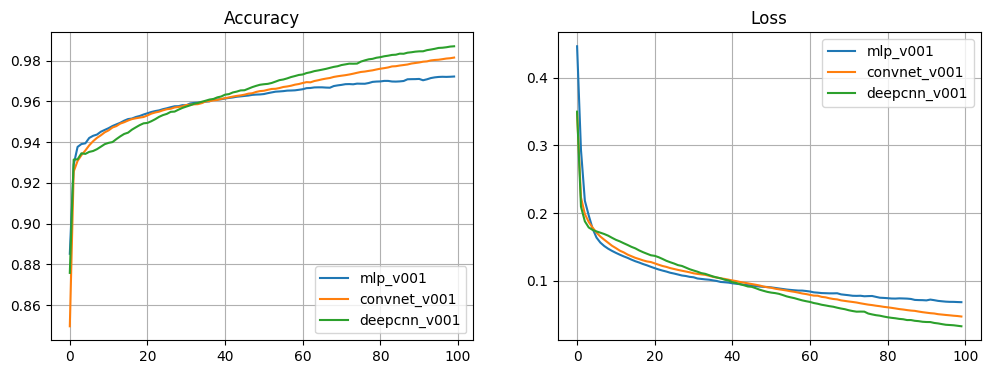

In [0]:
names = ['mlp_v001', 'convnet_v001', 'deepcnn_v001']
plot_models_history(names)

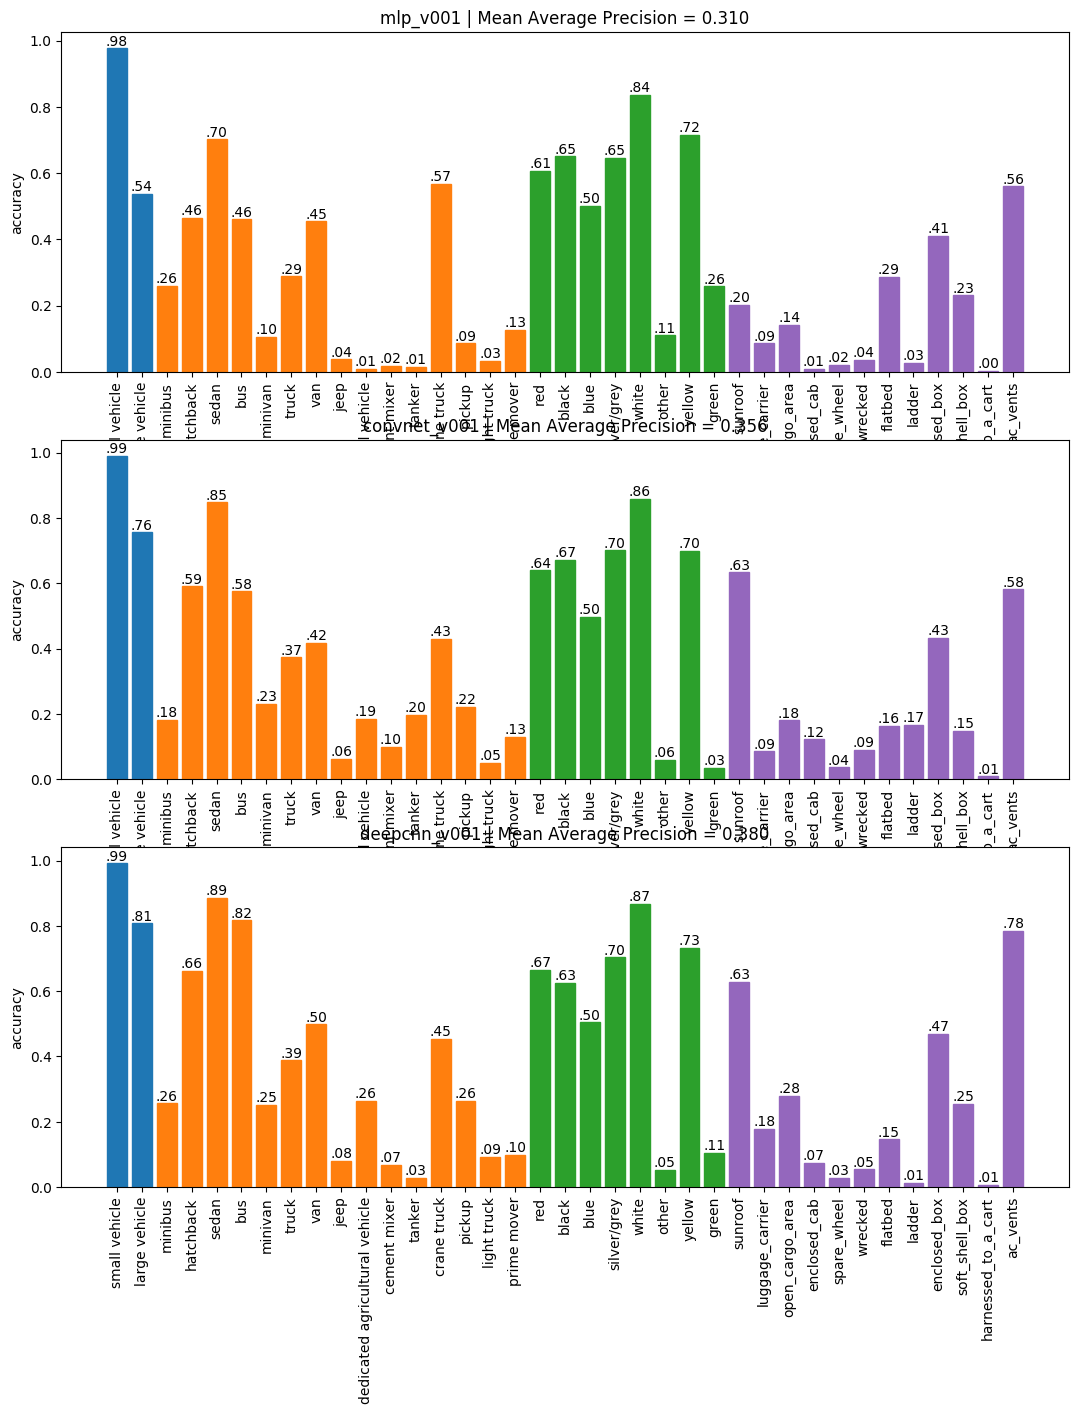

In [0]:
fig, ax = plt.subplots(3, figsize=(13, 15))
for i, model_name in enumerate(names):
  model = tf.keras.models.load_model(f'models/{model_name}.h5')
  pred = model.predict(X_test, batch_size=BATCH_SIZE)
  pred_df = postprocess_predictions(pred)
  plot_grades(grade(pred_df), model.name, ax=ax[i])

**Conclusions:**
* The simpler the model is the harder it is to fit (or overfit) the training data. Specifically, MLP is struggling in comparison to the convolutional models.
* Examining the per-class MAP score, we can see it's highly correlated to the examples ratios per-class. Thus, the class-imbalacing is our biggest issue.

In [0]:
def AverageEnsemble(models, input_shape):
  input_layer = layers.Input(shape=input_shape)
  x = tf.keras.layers.Average()([model(input_layer) for model in models])
  model = tf.keras.models.Model(input_layer, x, name='my-ensemble')
  return model


models = [tf.keras.models.load_model(f'models/{name}.h5') for name in names]
model = AverageEnsemble(models, input_shape=X_train.shape[1:])

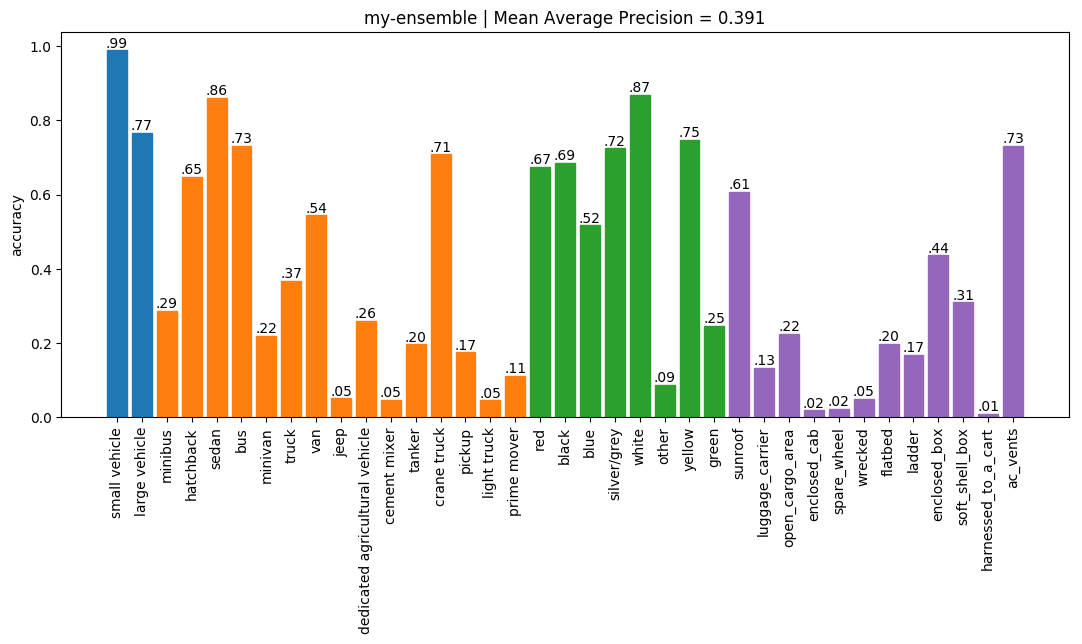

In [0]:
pred = model.predict(X_test, batch_size=BATCH_SIZE)
pred_df = postprocess_predictions(pred)
plot_grades(grade(pred_df), model.name)

## Baseline Model

* We choose our baseline model  to be a (relatively) small CNN model, but bigger than the previous models.
* The justifications is that the following size should be enough to grasph the complexity of the data.

In [0]:
def MyCNN(input_shape, classes, name):
  inputs = layers.Input(shape=input_shape)
  
  x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
  x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  
  x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
  x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  
  x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
  x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  
  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(classes, activation='sigmoid')(x)
  
  return tf.keras.models.Model(inputs, x, name=f'mycnn_{name}')

In [0]:
model = MyCNN(X_train.shape[1:], Y_train.shape[1], name='base')
model = to_tpu_model(model)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
csv_logger = tf.keras.callbacks.CSVLogger(f'models/{model.name}.csv')
model.fit(input_fn(X_train, Y_train),
          steps_per_epoch=10, epochs=100,
          callbacks=[csv_logger])
model.save(f'models/{model.name}.h5')
model = model.sync_to_cpu()

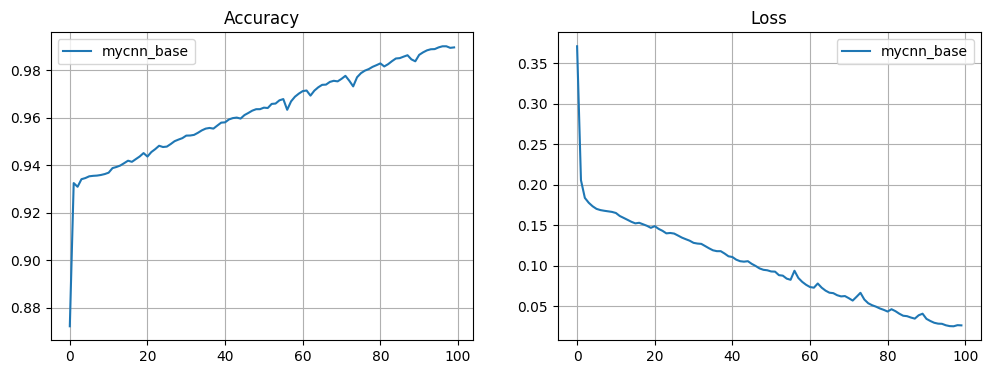

In [0]:
plot_models_history(['mycnn_base'])

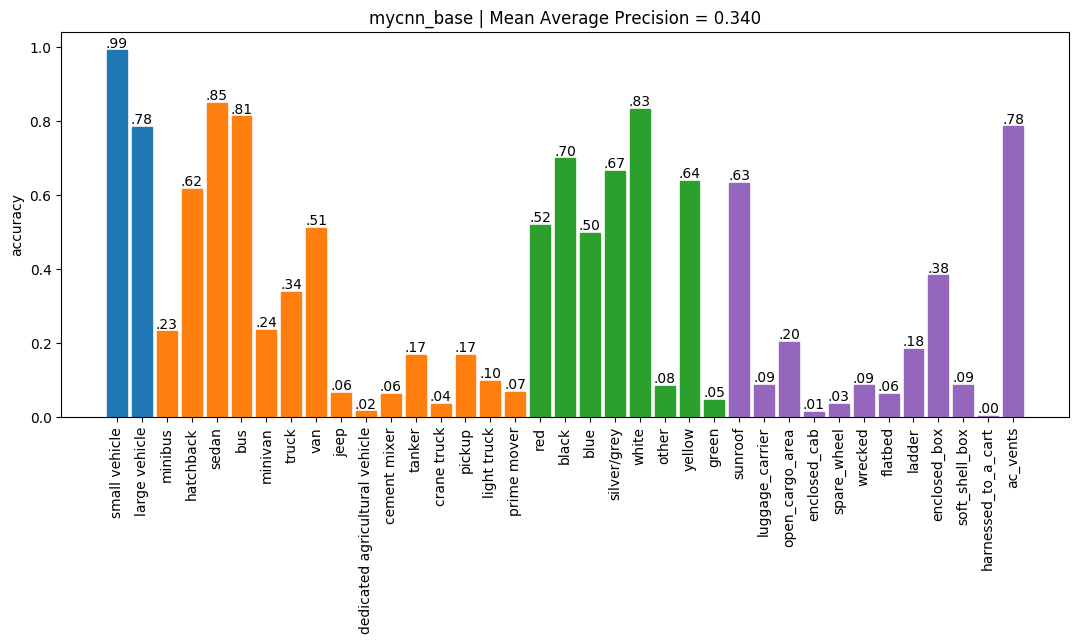

In [0]:
model = tf.keras.models.load_model(f'models/mycnn_base.h5')
pred = model.predict(X_test, batch_size=BATCH_SIZE)
pred_df = postprocess_predictions(pred)
plot_grades(grade(pred_df), model.name)

### Adding some Weight

* We use `fit()`'s [`class_weight`](https://keras.io/models/sequential/#fit) argument as a tool to mimic a weighted loss, as a mean to deal with our class imbalance problem.
* Calculation is done based on the precentage of each class out of all the dataset.

In [0]:
x = Y_train.sum(axis=0)
class_weights = dict(enumerate(x.sum() / x))

In [0]:
model = MyCNN(X_train.shape[1:], Y_train.shape[1], name='class_weight')
model = to_tpu_model(model)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
csv_logger = tf.keras.callbacks.CSVLogger(f'models/{model.name}.csv')
model.fit(input_fn(X_train, Y_train),
          steps_per_epoch=10, epochs=100,
          callbacks=[csv_logger])
model.save(f'models/{model.name}.h5')
model = model.sync_to_cpu()

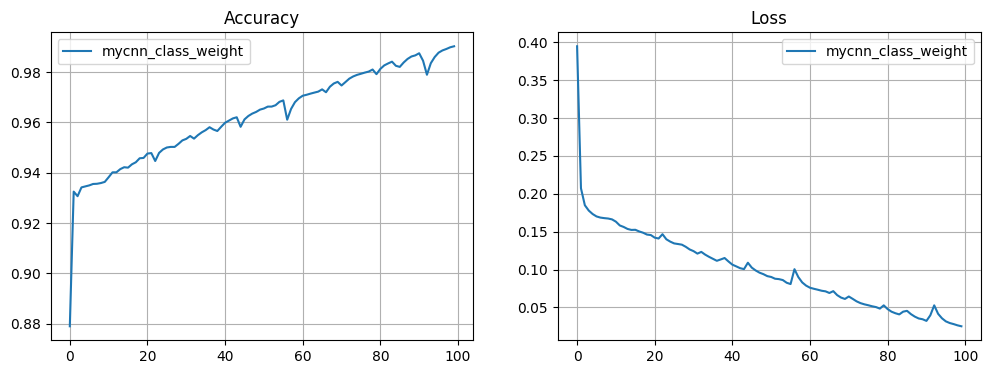

In [0]:
plot_models_history(['mycnn_class_weight'])

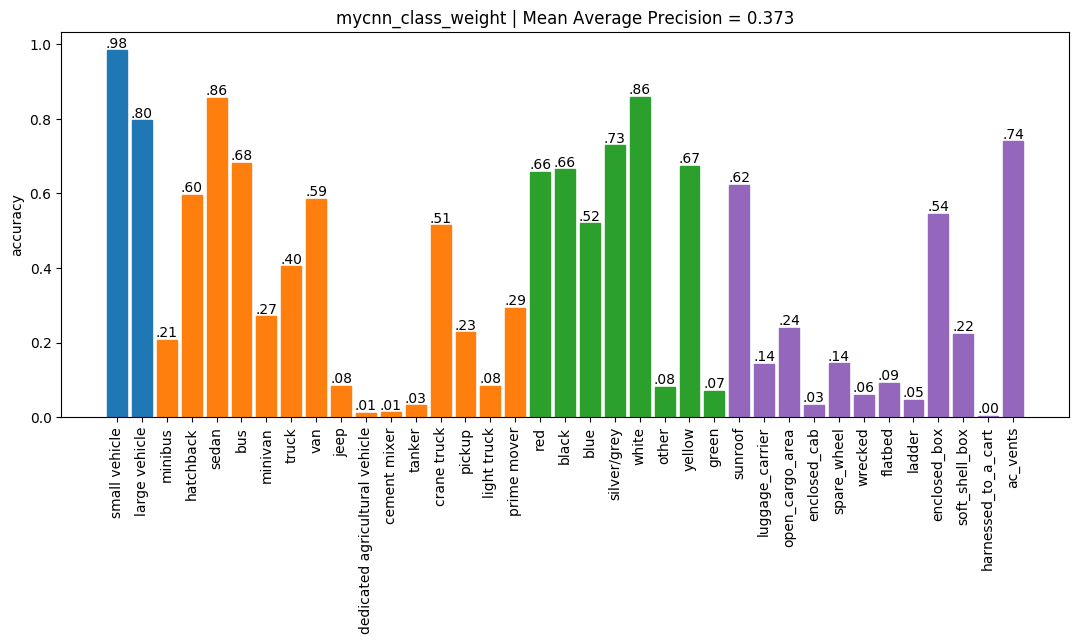

In [0]:
model = tf.keras.models.load_model(f'models/mycnn_class_weight.h5')
pred = model.predict(X_test, batch_size=BATCH_SIZE)
pred_df = postprocess_predictions(pred)
plot_grades(grade(pred_df), model.name)

**Conclusion**: Using `class_weight` improved our model accuracy on the test set by 15% approx.

### Basic Augmentation

* We add basic augmentation to our dataset.
* Each image is optionally flipped in each direction.
* Each image's controls (brightness, contrast) are being distorted.

In [0]:
def augment(image, label):
  image, label = augment_flip(image, label)
  image, label = augment_color_adj(image, label)
  return image, label

In [0]:
model = MyCNN(X_train.shape[1:], Y_train.shape[1], name='basic_aug')
model = to_tpu_model(model)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
csv_logger = tf.keras.callbacks.CSVLogger(f'models/{model.name}.csv')
model.fit(input_fn(X_train, Y_train, augment_fn=augment),
          steps_per_epoch=10, epochs=100,
          callbacks=[csv_logger])
model.save(f'models/{model.name}.h5')
model = model.sync_to_cpu()

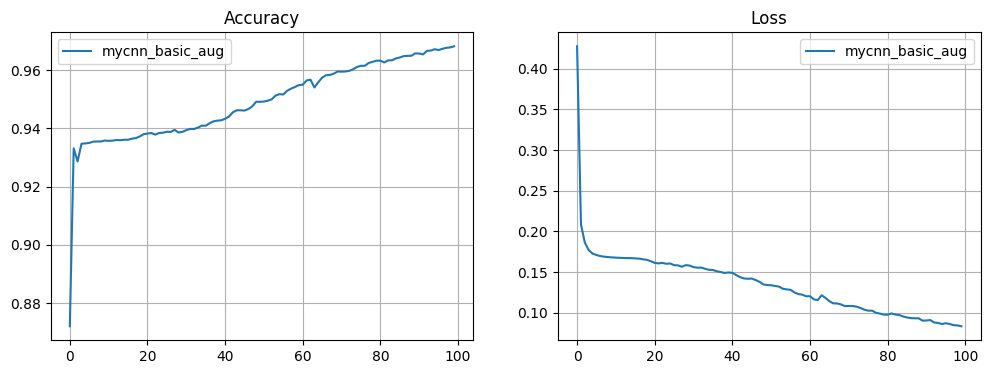

In [0]:
plot_models_history(['mycnn_basic_aug'])

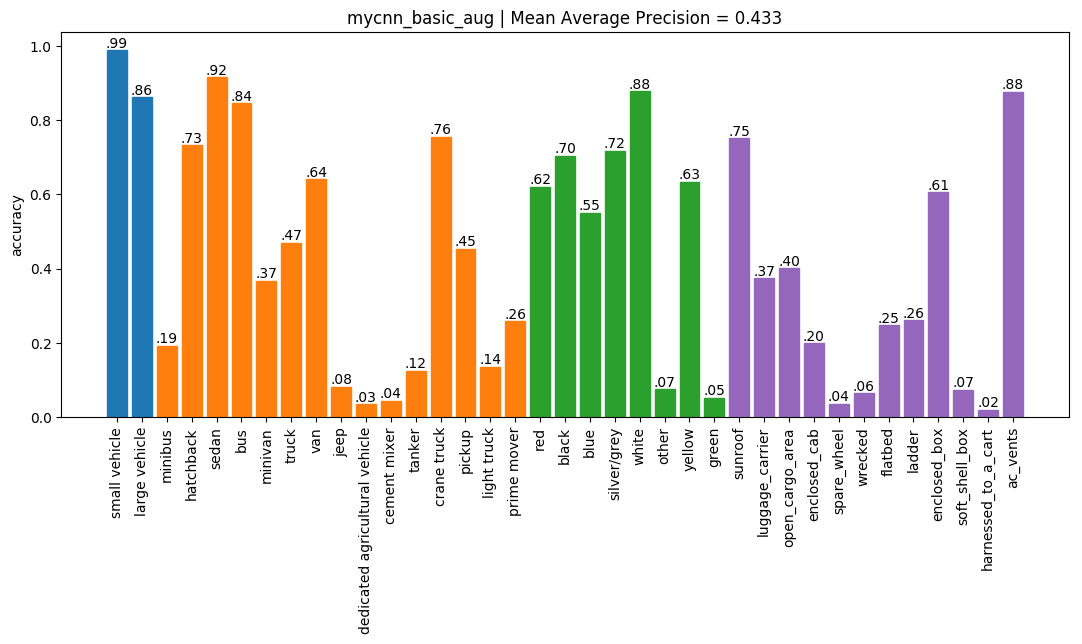

In [0]:
model = tf.keras.models.load_model(f'models/mycnn_basic_aug.h5')
pred = model.predict(X_test, batch_size=BATCH_SIZE)
pred_df = postprocess_predictions(pred)
plot_grades(grade(pred_df), model.name)

**Conclusion:** Even basic augmentaion does the job.
We improved the model accuracy on the test dataset by approximately 10%!

### Augmentation with custom loss

In [0]:
model = MyCNN(X_train.shape[1:], Y_train.shape[1], name='aug_w_class_weight')
model = to_tpu_model(model)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
csv_logger = tf.keras.callbacks.CSVLogger(f'models/{model.name}.csv')
model.fit(input_fn(X_train, Y_train, augment_fn=augment),
          steps_per_epoch=10, epochs=100,
          class_weight=class_weights,
          callbacks=[csv_logger])
model.save(f'models/{model.name}.h5')
model = model.sync_to_cpu()

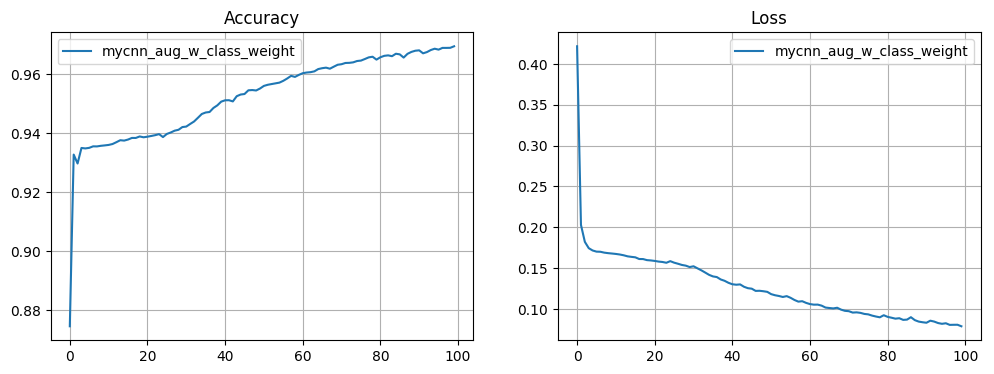

In [0]:
plot_models_history(['mycnn_aug_w_class_weight'])

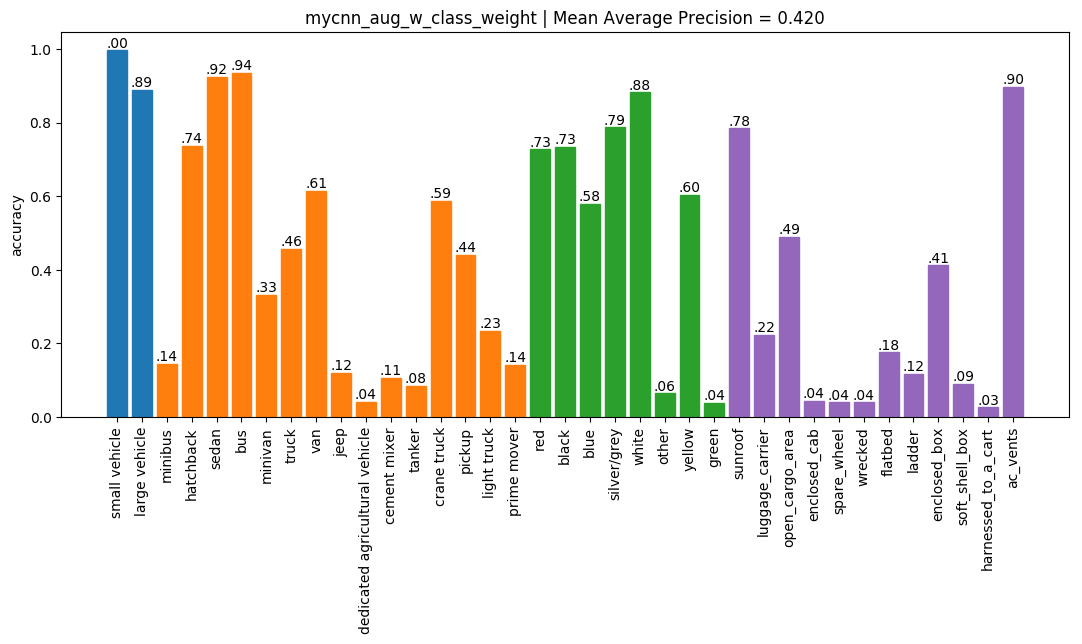

In [0]:
model = tf.keras.models.load_model(f'models/mycnn_aug_w_class_weight.h5')
pred = model.predict(X_test, batch_size=BATCH_SIZE)
pred_df = postprocess_predictions(pred)
plot_grades(grade(pred_df), model.name)

### Learning on the augmented dataset

In [0]:
classes_names = ['general_class', 'sub_class', 'color']
features_names = ['sunroof', 'luggage_carrier', 'open_cargo_area',
                  'enclosed_cab', 'spare_wheel', 'wrecked', 'flatbed',
                  'ladder', 'enclosed_box', 'soft_shell_box',
                  'harnessed_to_a_cart', 'ac_vents']

Y_names = ['small vehicle', 'large vehicle', 'minibus', 'hatchback', 'sedan', 'bus', 'minivan', 'truck', 'van', 'jeep', 'dedicated agricultural vehicle', 'cement mixer', 'tanker', 'crane truck', 'pickup', 'light truck', 'prime mover', 'red', 'black', 'blue', 'silver/grey', 'white', 'other', 'yellow', 'green', 'sunroof', 'luggage_carrier', 'open_cargo_area', 'enclosed_cab', 'spare_wheel', 'wrecked', 'flatbed', 'ladder', 'enclosed_box', 'soft_shell_box', 'harnessed_to_a_cart', 'ac_vents']

Y_train_aug_df = pd.get_dummies(augmented_df[classes_names], prefix='', prefix_sep='')
Y_train_aug_df = Y_train_aug_df.join(augmented_df[features_names].replace(-1, 0))[Y_names]
Y_train_aug = Y_train_aug_df.values.astype(np.float32)

x = Y_train_aug.sum(axis=0)
class_weights = dict(enumerate(x.sum() / x))

In [0]:
model = MyCNN(IMG_SHAPE, Y_train_aug.shape[1], name='aug_rgb')
model = to_tpu_model(model)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
csv_logger = tf.keras.callbacks.CSVLogger(f'models/{model.name}.csv')
model.fit(input_fn(X_train_aug_rgb, Y_train_aug, augment_fn=augment),
          steps_per_epoch=10, epochs=100,
          class_weight=class_weights,
          callbacks=[csv_logger])
model.save(f'models/{model.name}.h5')
model = model.sync_to_cpu()

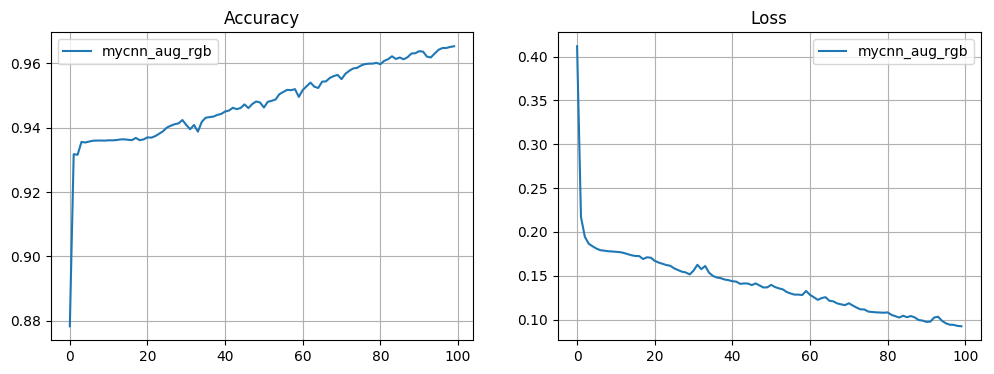

In [0]:
plot_models_history(['mycnn_aug_rgb'])

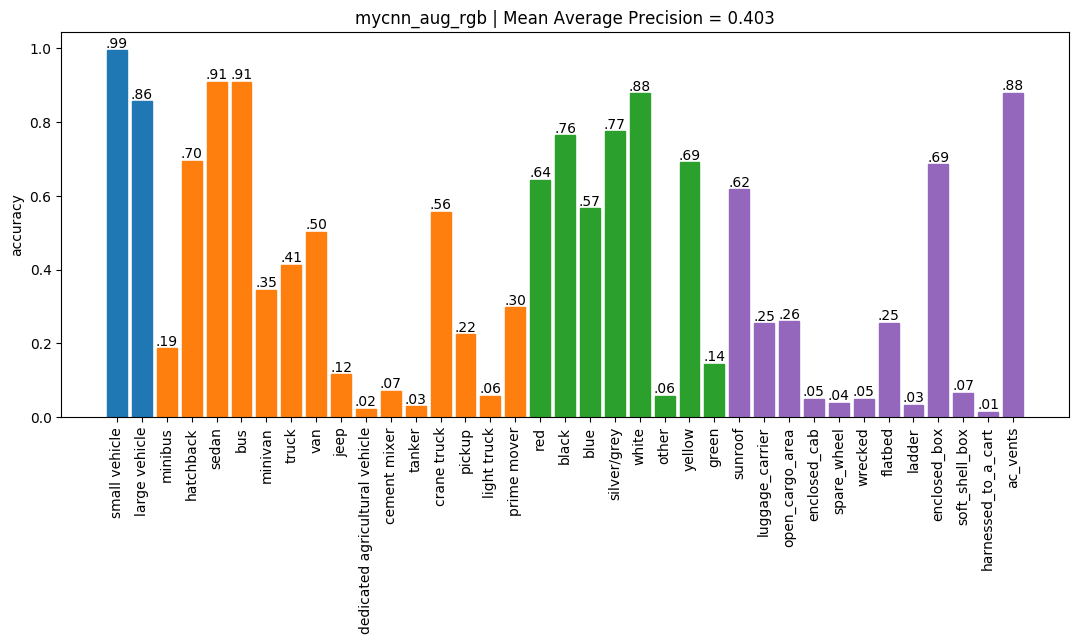

In [0]:
model = tf.keras.models.load_model(f'models/mycnn_aug_rgb.h5')
pred = model.predict(X_test_black, batch_size=BATCH_SIZE)
pred_df = postprocess_predictions(pred)
plot_grades(grade(pred_df), model.name)

**Conclusion:** Surprisingly, learning on black background and augmented color images reached lower success percentages than the original images.

## Transfer Learning

* Transfer Learning suppose to be the easiest way to "get going".
* We focus on two successful models: `VGG19` and `ResNet50`.
* We do not freeze the models weights while fine-tuning (after trying that too).

In [0]:
def from_keras_model(keras_model, input_shape, classes, name, trainable=False):
  model = keras_model(weights='imagenet',
                      include_top=False,
                      input_shape=input_shape)
  if not trainable:
    for layer in model.layers:
      layer.trainable = False
  x = layers.Flatten(name='flatten')(model.output)
  x = layers.Dense(1024, activation='relu', name='fc_1024')(x)
  x = layers.Dense(classes, activation='sigmoid', name='predictions')(x)
  return tf.keras.models.Model(model.input, x, name=f'{model.name}_{name}')

In [0]:
model = from_keras_model(tf.keras.applications.vgg19.VGG19,
                         input_shape=X_train.shape[1:],
                         classes=Y_train.shape[1],
                         name='v001',
                         trainable=True)
model = to_tpu_model(model)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
csv_logger = tf.keras.callbacks.CSVLogger(f'models/{model.name}.csv')
model.fit(input_fn(X_train, Y_train, augment_fn=augment),
          steps_per_epoch=10, epochs=100,
          callbacks=[csv_logger])
model.save(f'models/{model.name}.h5')
model = model.sync_to_cpu()

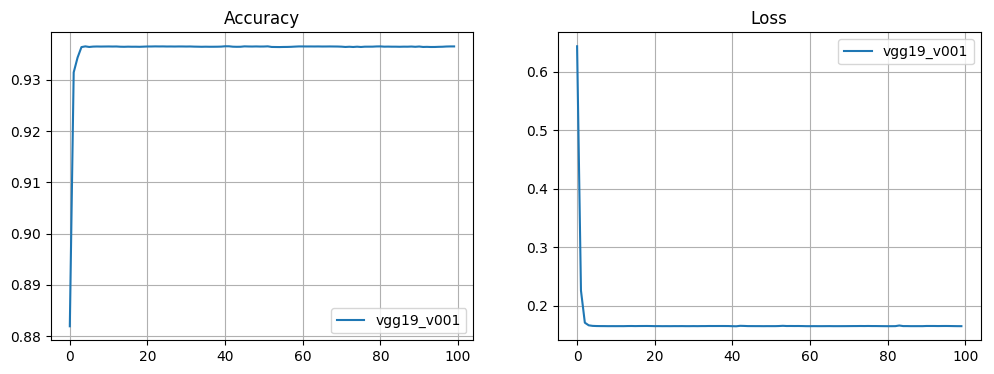

In [0]:
plot_models_history(['vgg19_v001'])

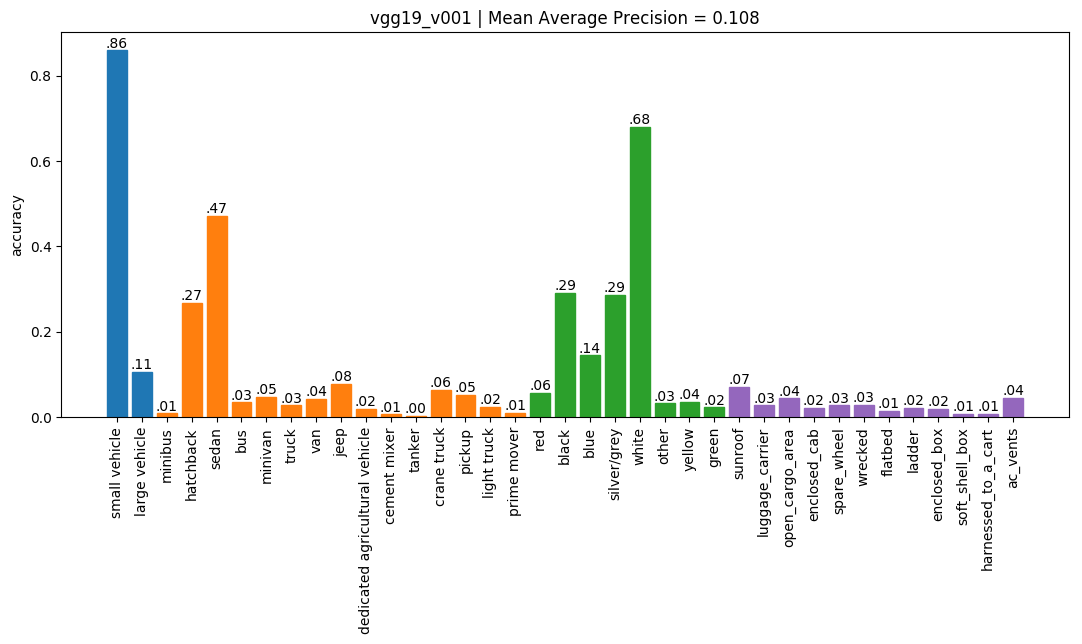

In [0]:
model = tf.keras.models.load_model(f'models/vgg19_v001.h5')
pred = model.predict(X_test, batch_size=BATCH_SIZE)
sorted_pred = np.argsort(-pred, axis=0)
pred_df = pd.DataFrame(data=test_df['tag_id'].values[sorted_pred],
                       columns=Y_names)
plot_grades(grade(pred_df), model.name)

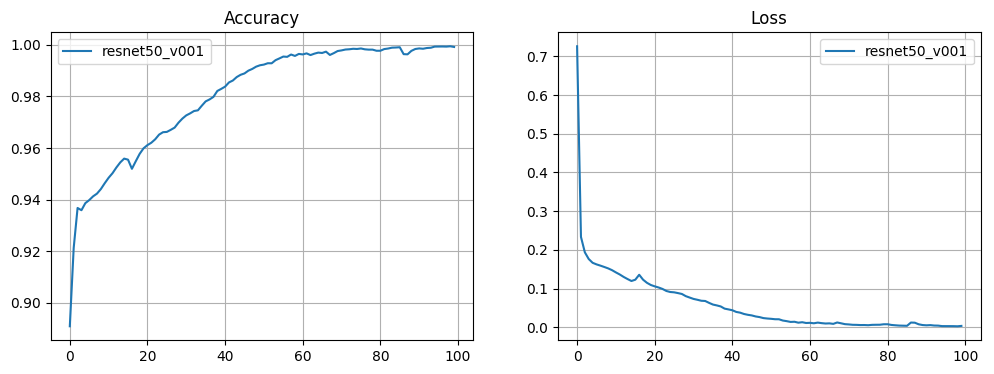

In [0]:
plot_models_history(['resnet50_v001'])

In [0]:
model = tf.keras.models.load_model(f'models/resnet50_v001.h5')
pred = model.predict(X_test, batch_size=BATCH_SIZE)
pred_df = postprocess_predictions(pred)
plot_grades(grade(pred_df), model.name)

**Conclusion:** `VGG19` Looks like it doesn't get the complexity of the data. `ResNet50` is better. We assume that the original *ImageNet* dataset is too different from our dataset for this kind of transfer learning to work.

# Challenge Summary

* We started off without prior knowledge of Deep learning or Convolutional Neural Networks.
* Our data exploration stage helped us understand where are our main challenges (class imbalance, small dataset, ambiguous even to human eye)
* We got a "grader" (or, a way to use evaluate our training data) only towards the end of the process, and thus we split our project to two points of focus.
* For color classification, we started off slowly by first overfitting our training data and tried to generalize more and more by using some conventional and unconventional augmentation techniques and trying out different models. We derived relevant conclusions regarding each step and made changes accordingly.
* For the raking problem (the original), We tried to use our prior knowledge from dealing with the color classification. One of the main keys was the understanding that this is not a classification problem, which required a shift of mind. We read and tried some transfer learning techniques and derived an impressive improvement in test accuracy with each step we took (well, most of them)

We had a huge fun working on such a new field of exploration. We learned so much though the process.